<a href="https://colab.research.google.com/github/UMassIonTrappers/Introduction-to-Quantum-Computing/blob/main/labs/Lab_09_QEC_Quantum_Error_Correction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECE 550/650

## Introduction to Quantum Computing

Robert Niffenegger (rniffenegger@umass.edu )

In [1110]:
try:
  import qiskit
  print('Qiskit imported')
except ImportError:
  print('Install Qiskit')
  !pip install --quiet qiskit
  !pip install --quiet qiskit[visualization]
  # !pip install --quiet git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src
  
import qiskit
print('Qiskit version:', qiskit.__version__)

try:
  from qiskit_aer import QasmSimulator
  print('Qiskit Aer imported');
except ImportError:
  print('Install Qiskit-Aer')
  !pip install --quiet qiskit-aer

try:
  from qiskit_ibm_runtime import QiskitRuntimeService
  print('Qiskit-IBM-Runtime imported')

except ImportError:
  print('Install Qiskit-IBM-Runtime')
  !pip install --quiet qiskit-ibm-runtime
  !pip install --quiet qiskit_ibm_provider[visualization]

# !pip install --quiet graphviz
# !apt-get install graphviz

Qiskit imported
Qiskit version: 2.0.0
Qiskit Aer imported
Qiskit-IBM-Runtime imported


In [1111]:
# %matplotlib inline

from IPython.display import display, Math
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi, sqrt, sin, cos

# Plot setup
from pylab import *
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML

# Qiskit imports
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_bloch_multivector, plot_histogram, plot_state_city
from qiskit_aer import QasmSimulator
from qiskit.quantum_info import Statevector
from qiskit.visualization import array_to_latex

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, thermal_relaxation_error, pauli_error


In [1112]:
'''https://github.com/qiskit-community/qiskit-ignis/blob/stable/0.3/qiskit/ignis/verification/tomography/data.py'''
# Needed for functions
from itertools import combinations
from functools import reduce
from re import match
from typing import Dict, Union, List

def combine_counts(counts1: Dict[str, int],
                   counts2: Dict[str, int]
                   ) -> Dict[str, int]:
    """Combine two counts dictionaries.
    Args:
        counts1: One of the count dictionaries to combine.
        counts2: One of the count dictionaries to combine.
    Returns:
        A dict containing the **sum** of entries in counts1 and counts2
        where a nonexisting entry is treated as 0
    Example:
        >>> counts1 = {'00': 3, '01': 5}
        >>> counts2 = {'00': 4, '10': 7}
        >>> combine_counts(counts1, counts2)
        {'00': 7, '01': 5, '10': 7}
    """
    ret = counts1
    for key, val in counts2.items():
        if key in ret:
            ret[key] += val
        else:
            ret[key] = val
    return ret

# Quantum Error Correction

Quantum systems are inherently fragile and susceptible to errors from environmental interactions. 

This lab introduces the fundamental concepts of quantum error correction (QEC) and demonstrates how we can detect qubit errors using redundancy and syndrome measurements.

### Objectives
1. Measure bit and phase errors
1. Implement 3 qubit repetition code
1. Perform syndrome measurements
1. Concatenate QEC codes
1. Run on real QPUs
 

### References
- https://arxiv.org/abs/0905.2794 - Quantum Error Correction for Beginners  (Simon J. Devitt, Kae Nemoto, William J. Munro)
- Nielsen & Chuang: Chapter 10 (Quantum Error Correction)
- [IBM Quantum Error Correction Tutorial](https://qiskit.org/textbook/ch-quantum-hardware/error-correction-repetition-code.html)
- https://learning.quantum.ibm.com/course/foundations-of-quantum-error-correction/correcting-quantum-errors
- John Watrous' notes (at IBM now) - https://cs.uwaterloo.ca/~watrous/QC-notes/QC-notes.pdf

# Part 1: Quantum Errors

Unlike classical bits which only experience bit flips (0→1 or 1→0), quantum bits can experience:

1. **Bit Flip Errors**: |0⟩ ↔ |1⟩ (X gate)
2. **Phase Flip Errors**: |+⟩ ↔ |-⟩ (Z gate)
3. **Combined Errors**: Both bit and phase flips (Y gate)
4. **Decoherence**: Loss of quantum information to the environment

Let's start by simulating these errors on a single qubit.

In [5]:
QasmSim = QasmSimulator() #Set simulator to evolve state

def apply_random_error(qc, qubit_idx, p_x, p_z):
    """Apply random X or Z error with given probabilities
    
    Args:
        qc (QuantumCircuit): Circuit to apply error to
        qubit_idx (int): Index of qubit to apply error
        p_x (float): Probability of X error
        p_z (float): Probability of Z error
    """
    r = np.random.random()
    if r < p_x:
        qc.x(qubit_idx)  # Bit flip
    elif r < p_x + p_z:
        qc.z(qubit_idx)  # Phase flip

def ideal_sim(qc,shots=100):
    job = QasmSim.run(qc, shots=shots)
    result = job.result()
    count = result.get_counts()
    return count

# def single_qubit_error_demo(p_error=0.2):
#     """Demonstrate errors on a single qubit"""
#     qc = create_error_circuit(p_error=p_error)

#     job = QasmSim.run(qc, shots=1)
#     result = job.result()
#     count = result.get_counts()
#     return count

def create_error_circuit(p_error=0.2):
    """Create quantum circuit with random error"""
    qc = QuantumCircuit(1, 1)
    qc.h(0)    # Prepare |+⟩ state
    qc.barrier()
    apply_random_error(qc, 0, p_x=p_error, p_z=p_error)
    qc.barrier()
    qc.h(0)
    qc.measure(0, 0)
    return qc

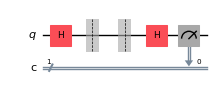

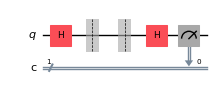

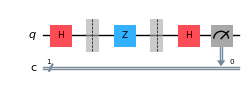

In [6]:
# Create and draw example circuit
circuits = []
for i in range(3):
    qc = create_error_circuit(p_error=0.2)
    display(qc.draw('mpl',scale=0.5))

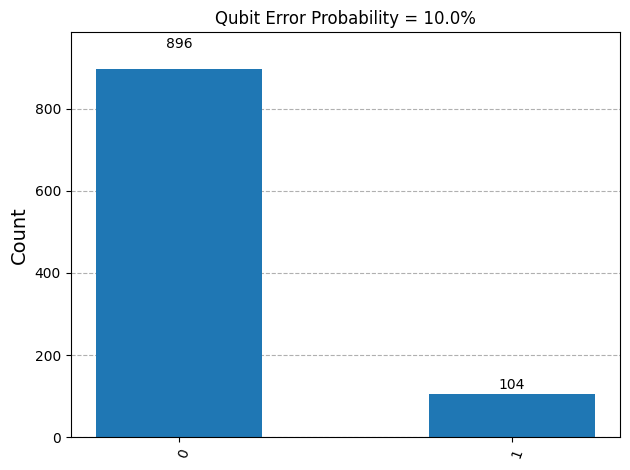

In [7]:
'''Run simulation many times with random errors each instance'''

nshots = 1000
shots = arange(nshots)

p_error = 0.1

counts = {}
for shot in shots: 
    counts = combine_counts(counts,ideal_sim(create_error_circuit(p_error=p_error),shots=1))

plot_histogram(counts, title=('Qubit Error Probability = ' + str(p_error*100) + '%') , sort='asc')

## Run on IBM QPU

In [8]:
# Check if token needs to be set
token = "INSERT YOUR TOKEN HERE"

# https://quantum.ibm.com/
if token == "INSERT YOUR TOKEN HERE":
    token = input("Please enter your IBM Quantum token: ")

In [9]:
from qiskit_ibm_runtime import QiskitRuntimeService
 
QiskitRuntimeService.save_account(
  token=token,
  channel="ibm_quantum", # `channel` distinguishes between different account types
  overwrite=True,
  set_as_default=True
)


### Simulate

In [17]:
from qiskit_ibm_runtime.fake_provider import FakeBrisbane , FakeSherbrooke
service = QiskitRuntimeService()

FakeBrisbane_backend = FakeBrisbane()
FakeBrisbane_backend.refresh(service)

FakeSherbrooke_backend = FakeSherbrooke()
FakeSherbrooke_backend.refresh(service)

backend = FakeSherbrooke_backend

In [13]:
def backend_sim(qc, backend=FakeSherbrooke_backend, shots=1000, optimization_level=3):
    """
    Run a quantum circuit on a backend with given number of shots
    
    Args:
        qc (QuantumCircuit): Circuit to run
        backend (Backend): Backend to run on, defaults to FakeBrisbane
        shots (int): Number of shots to run, defaults to 1000
        
    Returns:
        dict: Counts from running the circuit
    """

    pm = generate_preset_pass_manager(optimization_level=optimization_level, backend=backend, seed_transpiler=0)
    tqc = pm.run(qc)
    job = backend.run(tqc, shots=shots)
    result = job.result()
    counts = result.get_counts()
    return counts

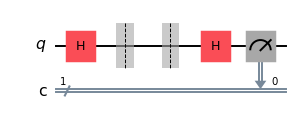

In [14]:
qc = create_error_circuit(p_error=0)
qc.draw('mpl',scale=0.7)

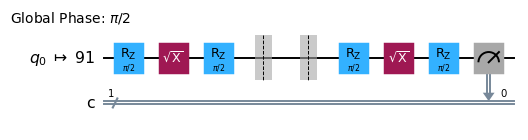

In [18]:
pm = generate_preset_pass_manager(optimization_level=3, backend=backend, seed_transpiler=0)
tqc = pm.run(qc)
tqc.draw('mpl',scale=0.7 ,fold = 100)

{'0': 9983, '1': 17}
Error rate: 0.17%


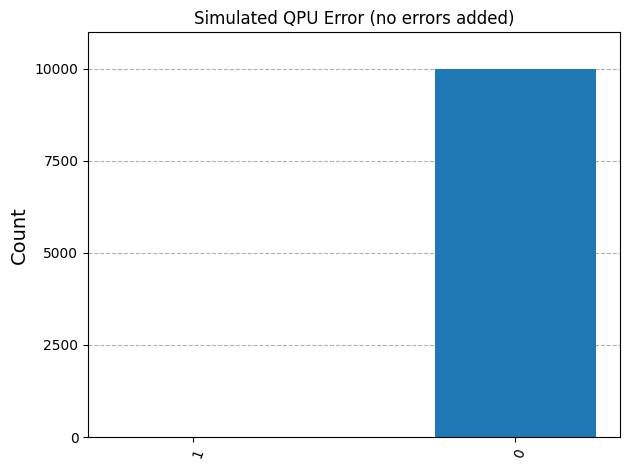

In [19]:
shots = 10000

counts = backend_sim(qc,shots=shots)

print(counts)
print(f"Error rate: {100*counts['1']/shots:.2f}%")

plot_histogram(counts,title='Simulated QPU Error (no errors added)' , sort = 'value', bar_labels=False)

### Real QPU

In [275]:
def backend_real(qc, backend=None, shots=1000, optimization_level=3):
    """
    Run a quantum circuit on a real QPU backend
    
    Args:
        qc (QuantumCircuit): Circuit to run
        backend (Backend): Backend to run on, defaults to most idle QPU
        shots (int): Number of shots to run, defaults to 1000
        
    Returns:
        dict: Counts from running the circuit
    """

    if backend is None:
        service = QiskitRuntimeService()
        backend = service.least_busy(operational=True, simulator=False)
        print(backend)

    pm = generate_preset_pass_manager(optimization_level=optimization_level, backend=backend, seed_transpiler=0)
    tqc = pm.run(qc)

    sampler = Sampler(backend)
    job = sampler.run([tqc],shots=shots)

    result = job.result()
    try:
        counts = result[0].data.c.get_counts()
    except AttributeError:
        counts = result[0].data.s.get_counts()

    return counts

<IBMBackend('ibm_sherbrooke')>
Error rate: 0.10%


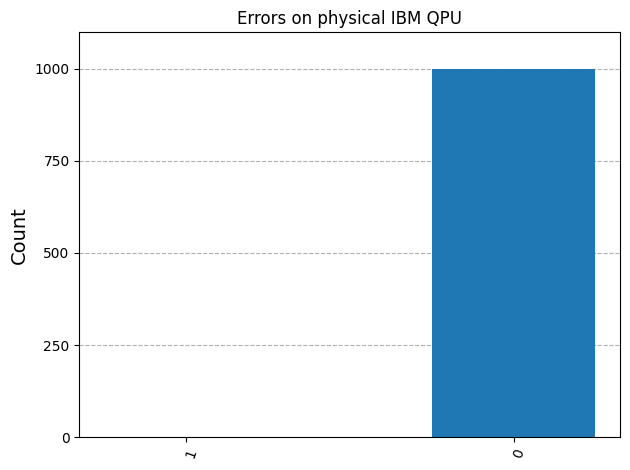

In [15]:
counts = backend_real(qc)  

if '1' in counts:
    print(f"Error rate: {100*counts['1']/shots:.2f}%")

plot_histogram(counts,title='Errors on physical IBM QPU',bar_labels=False,sort='value')

# Part 2: The 3-Qubit Bit Flip Code (repetition code)

The simplest quantum error correction code protects against bit flip errors by encoding:
- $|0⟩ → |000⟩$
- $|1⟩ → |111⟩$

This encoding allows us to detect and correct single bit flip errors through majority voting.

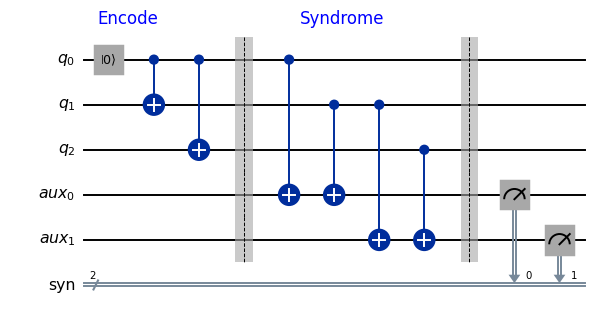

In [333]:
def create_3qubit_code():
    """Create a circuit implementing the 3-qubit bit flip code"""
    # Create registers
    qr = QuantumRegister(3, 'q')
    # cr = ClassicalRegister(3, 'c')
    aux = QuantumRegister(2, 'aux')  # Auxillary qubits for syndrome measurement
    syndrome = ClassicalRegister(2, 'syn')
    qc = QuantumCircuit(qr, aux, syndrome)
    
    # Initialize to |0> state
    qc.reset(0)
    # Encoding
    qc.cx(0, 1)  # Spread information to other qubits
    qc.cx(0, 2)
    
    # Add barrier to separate encoding
    qc.barrier()
    
    return qc

def add_syndrome_measurement(qc, with_barrier=True):
    """Add syndrome measurement circuit"""
    # Measure ZZ between first and second qubit
    qc.cx(0, 3)
    qc.cx(1, 3)
    # Measure ZZ between second and third qubit
    qc.cx(1, 4)
    qc.cx(2, 4)

    if with_barrier:
        qc.barrier()

    # Measure auxillary qubits
    qc.measure([3,4], [0,1])
    return qc

qc = create_3qubit_code()
qc = add_syndrome_measurement(qc)

fig = qc.draw(output='mpl', scale = 0.7)

ax = fig.axes[0]
ax.text(0.15, 1.0, 'Encode', transform=ax.transAxes, fontsize=12, color='blue')
ax.text(0.5, 1.0, 'Syndrome', transform=ax.transAxes, fontsize=12, color='blue')
display(fig)

## Syndrome Measurements

The syndrome measurements tell us which qubit (if any) experienced a bit flip:

| Syndrome | Error Location |
|----------|----------------|
| $0_{a1}$ $0_{a0}$       | No error      |
| $1_{a1}$ $0_{a0}$       | q2      |
| $1_{a1}$ $1_{a0}$       | q1      |
| $0_{a1}$ $1_{a0}$       | q0      |


Complete the following tasks:
1. Add random bit flip errors to the circuit
2. Interpret the syndrome measurements
3. Apply correction based on syndrome results

In [342]:
# Create circuit
def create_circuit_with_error(p_error):
    """Create a 3-qubit code circuit with random bit flip error
    
    Args:
        p_error (float): Probability of bit flip error on each qubit
        
    Returns:
        qc (QuantumCircuit): Circuit with encoding and error
        error_added (bool): Whether an error was added
    """
    qc = create_3qubit_code()
    
    error_added = False
    # Add random bit flip errors
    for i in range(3):
        if np.random.random() < p_error:
            qc.x(i)
            error_added = True
            break #only one error at a time!!!
    
    qc.barrier()
    
    # Add syndrome measurement
    qc = add_syndrome_measurement(qc)
    
    return qc

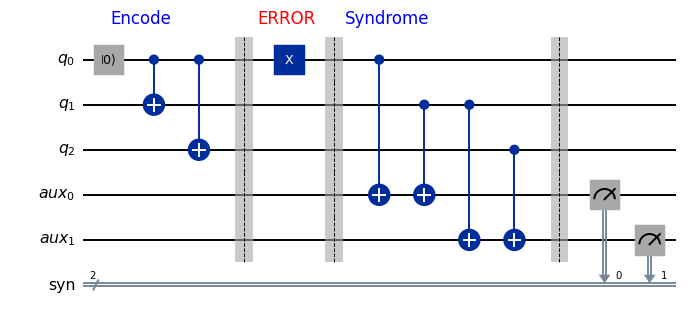

In [347]:
p_error = 0.3

qc = create_circuit_with_error(p_error)

fig = qc.draw(output='mpl', scale = 0.7)

ax = fig.axes[0]
ax.text(0.15, 1.0, 'Encode', transform=ax.transAxes, fontsize=12, color='blue')
ax.text(0.37, 1.0, 'ERROR', transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.5, 1.0, 'Syndrome', transform=ax.transAxes, fontsize=12, color='blue')
display(fig)

In [348]:
counts = ideal_sim(qc,shots=100)
print(counts)
# plot_histogram(counts, title='Syndrome Measurement (ideal simulation without noise)' , sort='asc', figsize=(6,5))

{'01': 100}


Error detected on qubit 0


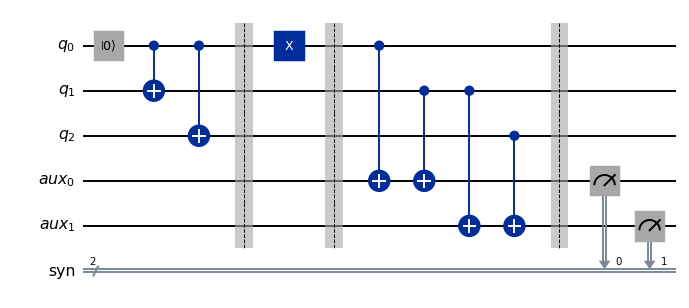

In [349]:
def decode_syndrome(counts):
    syndrome = list(counts.keys())[0] #get only a single shot (first)
    syndrome_table = {
        '00': -1,  # No error
        '01': 0,   # Error on qubit 0 
        '11': 1,    # Error on qubit 1
        '10': 2   # Error on qubit 2
    }
    error_qubit = syndrome_table[syndrome]
    
    if error_qubit == -1:
        print("No error detected")
    else:
        print(f"Error detected on qubit {error_qubit}")
    return error_qubit

decode_syndrome(counts)
qc.draw('mpl',scale=0.7)

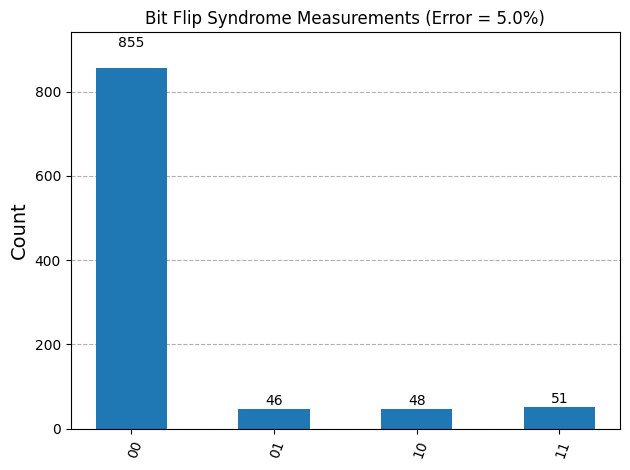

In [350]:
p_error=0.05
ntrials = 1000
trials = arange(ntrials)
counts = {}

for trial in trials: 
    # Create a circuit with potential error based on p_error probability
    circuit_with_error = create_circuit_with_error(p_error)

    # Run ideal simulation for 1 shot to get measurement results
    sim_results = ideal_sim(circuit_with_error, shots=1)
    
    # Combine these results with previous counts
    counts = combine_counts(counts, sim_results)

plot_histogram(counts, title=('Bit Flip Syndrome Measurements (Error = ' + str(round(p_error*100,2)) + '%)') , sort='asc')

## Simulate on fake QPU

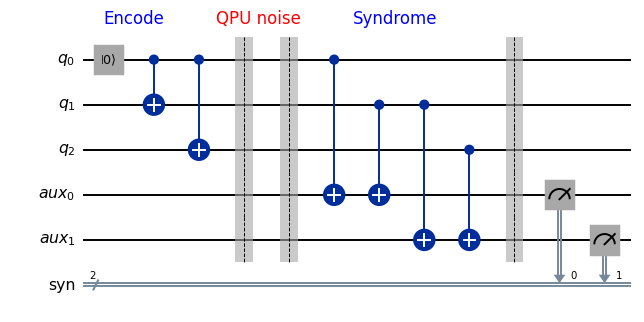

In [351]:
qc = create_circuit_with_error(p_error=0.0)

fig = qc.draw(output='mpl', scale = 0.7)

ax = fig.axes[0]
ax.text(0.15, 1.0, 'Encode', transform=ax.transAxes, fontsize=12, color='blue')
ax.text(0.33, 1.0, 'QPU noise', transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.55, 1.0, 'Syndrome', transform=ax.transAxes, fontsize=12, color='blue')
display(fig)

{'00': 919, '01': 51, '10': 19, '11': 11}
Error Analysis:
No error (00): 91.90%
Q0 error (10): 1.90%
Q1 error (11): 1.10%
Q2 error (01): 5.10%


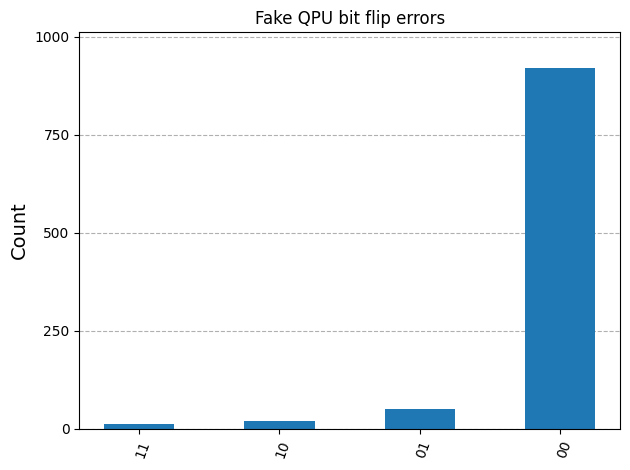

In [352]:
shots = 1000
counts = backend_sim(qc, backend=FakeSherbrooke_backend , shots=shots)

# Reverse string of counts and decode
reversed_counts = {k[::-1]: v for k, v in counts.items()}
print(reversed_counts)

no_error = reversed_counts['00']/shots * 100
q0_error = reversed_counts['10']/shots * 100
q1_error = reversed_counts['11']/shots * 100
q2_error = reversed_counts['01']/shots * 100  

print(f"Error Analysis:")
print(f"No error (00): {no_error:.2f}%")
print(f"Q0 error (10): {q0_error:.2f}%")
print(f"Q1 error (11): {q1_error:.2f}%")
print(f"Q2 error (01): {q2_error:.2f}%") 

plot_histogram(reversed_counts,title='Fake QPU bit flip errors' , sort = 'value', bar_labels=False)

In [287]:
print(ideal_sim(qc))

{'00': 100}


## Real QPU

{'00': 853, '01': 63, '10': 69, '11': 15}
Error Analysis:
No error (00): 85.30%
Q0 error (10): 6.90%
Q1 error (11): 1.50%
Q2 error (01): 6.30%


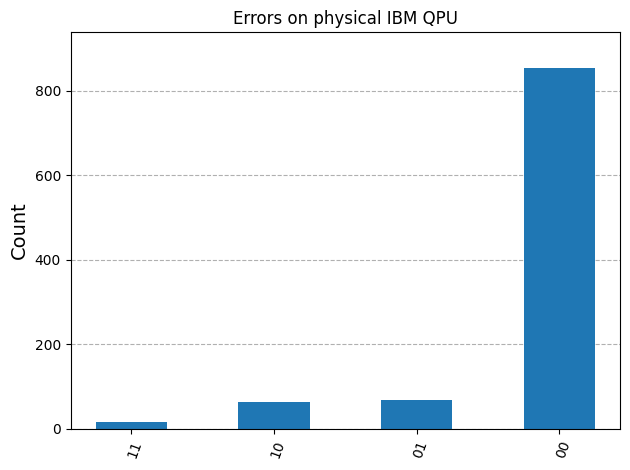

In [82]:
backend = service.backend('ibm_sherbrooke')

counts = backend_real(qc,backend=backend)

# Reverse string of counts and decode
reversed_counts = {k[::-1]: v for k, v in counts.items()}
print(reversed_counts)

no_error = reversed_counts['00']/shots * 100
q0_error = reversed_counts['10']/shots * 100
q1_error = reversed_counts['11']/shots * 100
q2_error = reversed_counts['01']/shots * 100  

print(f"Error Analysis:")
print(f"No error (00): {no_error:.2f}%")
print(f"Q0 error (10): {q0_error:.2f}%")
print(f"Q1 error (11): {q1_error:.2f}%")
print(f"Q2 error (01): {q2_error:.2f}%") 

plot_histogram(counts,title='Errors on physical IBM QPU',bar_labels=False,sort='value')

# The 3-Qubit Phase flip code
 
After looking at bit flip errors, we now turn our attention to phase flip errors.
Phase flip errors occur when a qubit's phase is inverted, changing the sign of the quantum state.
While bit flip errors flip between |0⟩ and |1⟩, phase flip errors flip between |+⟩ and |-⟩.

The 3-qubit phase flip code is similar to the bit flip code, but operates in the X-basis rather than Z-basis.
It uses Hadamard gates to transform between bases, encoding logical |+⟩ and |-⟩ states across 3 physical qubits.

Below we'll implement the encoding circuit for the 3-qubit phase flip code and examine how it protects against phase errors.

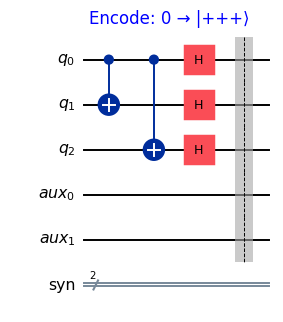

In [353]:
def create_3qubit_phase_code():
    """Create a circuit implementing the 3-qubit phase flip code"""
    qr = QuantumRegister(3, 'q')
    aux = QuantumRegister(2, 'aux')  # Auxillary qubits for syndrome measurement
    syndrome = ClassicalRegister(2, 'syn')
    qc = QuantumCircuit(qr, aux, syndrome)
    
    # Encoding
    qc.cx(0, 1)  # Spread information to other qubits
    qc.cx(0, 2)
    for qubit in range(0,3):
        qc.h(qubit)
    # Add barrier to separate encoding
    qc.barrier()
    return qc

qc = create_3qubit_phase_code()

fig = qc.draw(output='mpl', scale = 0.7)
ax = fig.axes[0]
ax.text(0.3, 1.0, 'Encode: 0 → |+++⟩', transform=ax.transAxes, fontsize=12, color='blue')
display(fig)

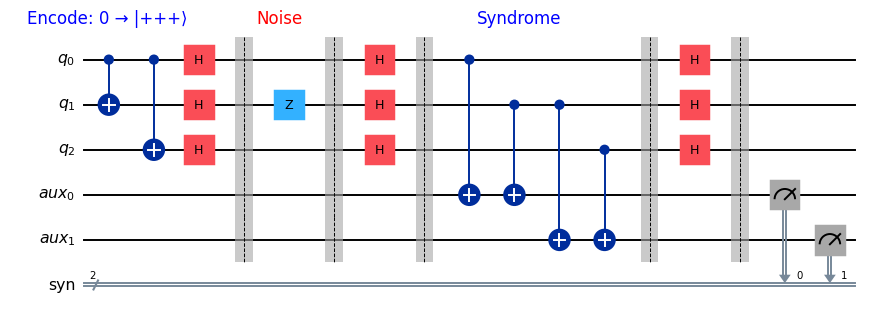

In [354]:
def add_phase_syndrome_measurement(qc, with_barriers=True):
    """Add Phase syndrome measurement circuit"""

    for qubit in range(0,3):
        qc.h(qubit)
    if with_barriers:
        qc.barrier()

    # Measure ZZ between first and second qubit
    qc.cx(0, 3)
    qc.cx(1, 3)
    # Measure ZZ between second and third qubit
    qc.cx(1, 4)
    qc.cx(2, 4)

    qc.barrier()
    for qubit in range(0,3):
        qc.h(qubit)
    qc.barrier()

    # Measure auxillary qubits
    qc.measure([3,4], [0,1])
    return qc


def create_phase_code_with_error(p_error=0.3):
    """Create a 3-qubit phase code circuit with random phase flip error
    
    Args:
        p_error (float): Probability of phase flip error on each qubit
     
    Returns:
        QuantumCircuit: Circuit with encoding and random error
    """
    qc = create_3qubit_phase_code()

    # Add random phase flip errors
    for i in range(3):
        if np.random.random() < p_error:
            qc.z(i)
            break # only one error at a time!!

    qc.barrier()
    qc = add_phase_syndrome_measurement(qc)
    return qc

qc = create_phase_code_with_error()

fig = qc.draw(output='mpl', scale = 0.7)
ax = fig.axes[0]
ax.text(0.02, 1.0, 'Encode: 0 → |+++⟩', transform=ax.transAxes, fontsize=12, color='blue')
ax.text(0.29, 1.0, 'Noise', transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.55, 1.0, 'Syndrome', transform=ax.transAxes, fontsize=12, color='blue')
display(fig)

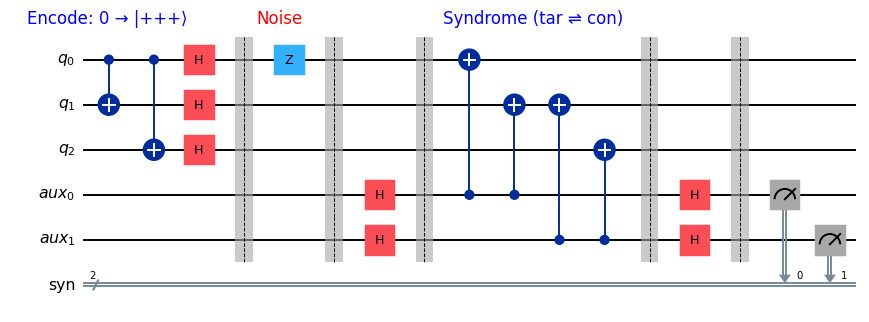

In [355]:
def add_phase_syndrome_measurement(qc, with_barriers=True):
    """Add Phase syndrome measurement circuit"""

    qc.h(3)
    qc.h(4)
    if with_barriers:
        qc.barrier()

    # Measure ZZ between first and second qubit
    qc.cx(3, 0) #reversed!
    qc.cx(3, 1) #reversed!

    # Measure ZZ between second and third qubit
    qc.cx(4, 1) #reversed!
    qc.cx(4, 2) #reversed!

    qc.barrier()
    qc.h(3)
    qc.h(4)
    qc.barrier()

    qc.measure([3,4], [0,1])# Measure auxillary
    return qc


def create_phase_code_with_error(p_error=0.3):
    """Create a 3-qubit phase code circuit with random phase flip error
    
    Args:
        p_error (float): Probability of phase flip error on each qubit
        
    Returns:
        QuantumCircuit: Circuit with encoding and random error
    """
    qc = create_3qubit_phase_code()

    # Add random phase flip errors
    for i in range(3):
        if np.random.random() < p_error:
            qc.z(i)
            break # only one error at a time!!

    qc.barrier()
    qc = add_phase_syndrome_measurement(qc)
    return qc

qc = create_phase_code_with_error()

fig = qc.draw(output='mpl', scale = 0.7)
ax = fig.axes[0]
ax.text(0.02, 1.0, 'Encode: 0 → |+++⟩', transform=ax.transAxes, fontsize=12, color='blue')
ax.text(0.29, 1.0, 'Noise', transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.51, 1.0, 'Syndrome (tar ⇌ con)', transform=ax.transAxes, fontsize=12, color='blue')
display(fig)

In [36]:
# job = QasmSim.run(qc, shots=1)
# result = job.result()
# counts = result.get_counts()
# plot_histogram(counts, title='Phase Syndrome Measurement (single shot)' , sort='asc')

{'00': 858, '11': 49, '10': 47, '01': 46}
{'00': 858, '11': 49, '01': 47, '10': 46}
Error Analysis:
No error (00): 85.80%
Q0 error (10): 4.60%
Q1 error (11): 4.90%
Q2 error (01): 4.70%


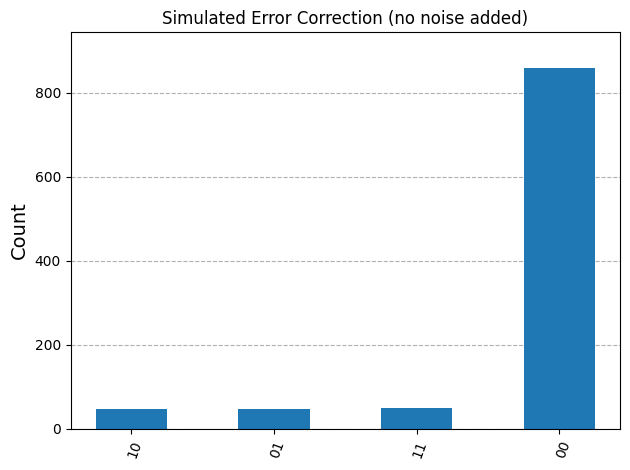

In [77]:
'''Run Simulation with errors and display Syndrome measurements'''

p_error=0.05

ntrials = 1000
trials = arange(ntrials)

counts = {}
for trial in trials: 
    qc = create_phase_code_with_error(p_error=p_error)
    counts = combine_counts(counts, ideal_sim(qc,shots=1))

print(counts)
shots=1000

# Reverse string of counts and decode
reversed_counts = {k[::-1]: v for k, v in counts.items()}
print(reversed_counts)

no_error = reversed_counts['00']/shots * 100
q0_error = reversed_counts['10']/shots * 100
q1_error = reversed_counts['11']/shots * 100
q2_error = reversed_counts['01']/shots * 100  

print(f"Error Analysis:")
print(f"No error (00): {no_error:.2f}%")
print(f"Q0 error (10): {q0_error:.2f}%")
print(f"Q1 error (11): {q1_error:.2f}%")
print(f"Q2 error (01): {q2_error:.2f}%") 

plot_histogram(reversed_counts,title='Simulated Error Correction (no noise added)' , sort = 'value', bar_labels=False)

## Simulate on QPU

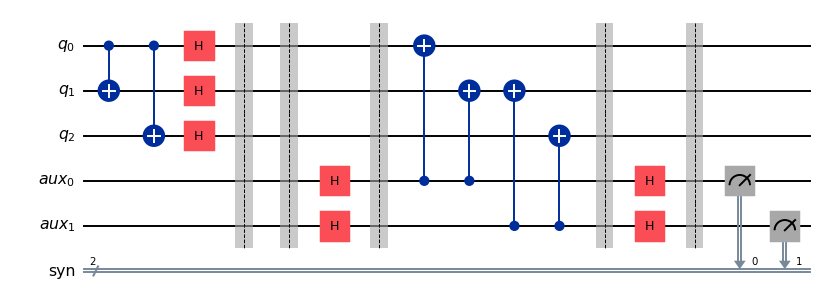

In [356]:
qc = create_phase_code_with_error(p_error=0.0)
qc.draw('mpl', scale=0.7)

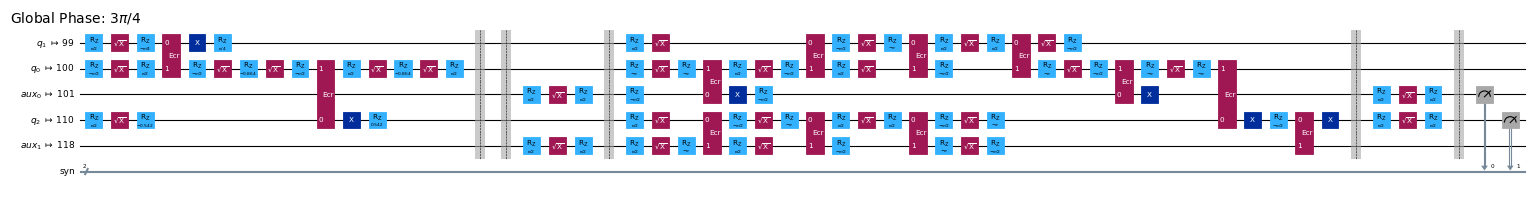

In [357]:
pm = generate_preset_pass_manager(optimization_level=3, backend=backend, seed_transpiler=1)
tqc = pm.run(qc)
tqc.draw('mpl',scale=0.4 ,fold = 100)

{'00': 932, '01': 31, '10': 12, '11': 25}
Error Analysis:
No error (00): 93.20%
Q0 error (10): 1.20%
Q1 error (11): 2.50%
Q2 error (01): 3.10%


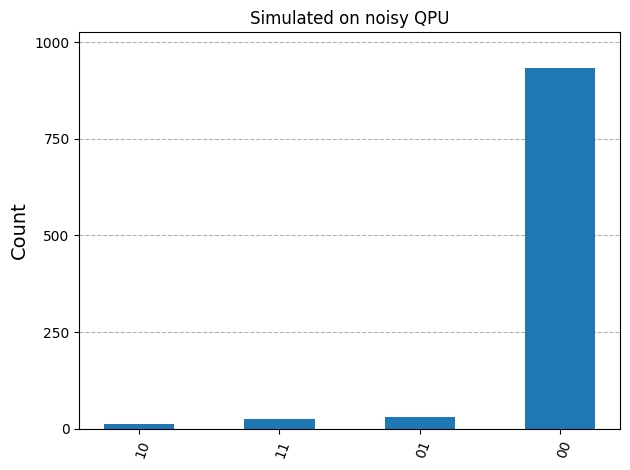

In [358]:
counts = backend_sim(qc)

# Reverse string of counts and decode
reversed_counts = {k[::-1]: v for k, v in counts.items()}
print(reversed_counts)

no_error = reversed_counts['00']/shots * 100
q0_error = reversed_counts['10']/shots * 100
q1_error = reversed_counts['11']/shots * 100
q2_error = reversed_counts['01']/shots * 100  

print(f"Error Analysis:")
print(f"No error (00): {no_error:.2f}%")
print(f"Q0 error (10): {q0_error:.2f}%")
print(f"Q1 error (11): {q1_error:.2f}%")
print(f"Q2 error (01): {q2_error:.2f}%") 

plot_histogram(reversed_counts,title='Simulated on noisy QPU' , sort = 'value', bar_labels=False)

Excellent. Shots with no errors are most likely by far!

## Phase flips on real QPU

{'11': 65, '00': 665, '01': 124, '10': 146}
Error Analysis:
No error (00): 66.50%
Q0 error (10): 14.60%
Q1 error (11): 6.50%
Q2 error (01): 12.40%


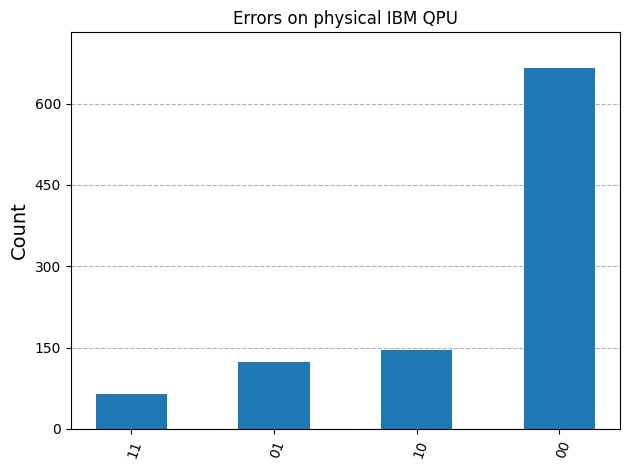

In [87]:

backend = service.backend('ibm_sherbrooke')

counts = backend_real(qc,backend=backend)

# Reverse string of counts and decode
reversed_counts = {k[::-1]: v for k, v in counts.items()}
print(reversed_counts)

no_error = reversed_counts['00']/shots * 100
q0_error = reversed_counts['10']/shots * 100
q1_error = reversed_counts['11']/shots * 100
q2_error = reversed_counts['01']/shots * 100  

print(f"Error Analysis:")
print(f"No error (00): {no_error:.2f}%")
print(f"Q0 error (10): {q0_error:.2f}%")
print(f"Q1 error (11): {q1_error:.2f}%")
print(f"Q2 error (01): {q2_error:.2f}%") 

plot_histogram(reversed_counts,title='Errors on physical IBM QPU' , sort = 'value', bar_labels=False)

Excellent the rate of phase errors is relatively low on a real QPU.

# Add a phase error (and use a noisy QPU) to verify decoding

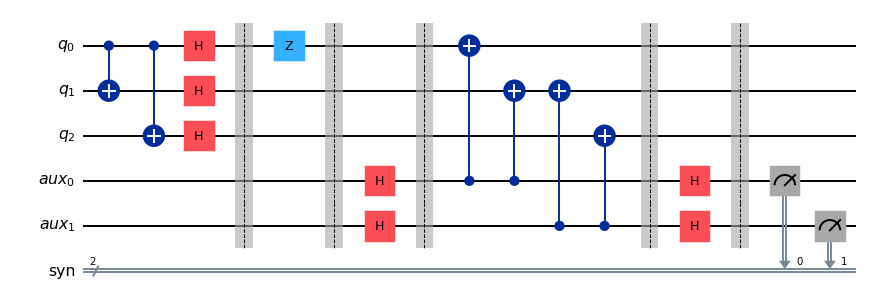

In [359]:
qc = create_phase_code_with_error(p_error=0.3)
qc.draw('mpl', scale=0.7)

In [360]:
counts = backend_real(qc)

# Reverse string of counts and decode
reversed_counts = {k[::-1]: v for k, v in counts.items()}
print(reversed_counts)

no_error = reversed_counts['00']/shots * 100
q0_error = reversed_counts['10']/shots * 100
q1_error = reversed_counts['11']/shots * 100
q2_error = reversed_counts['01']/shots * 100  

print(f"Error Analysis:")
print(f"No error (00): {no_error:.2f}%")
print(f"Q0 error (10): {q0_error:.2f}%")
print(f"Q1 error (11): {q1_error:.2f}%")
print(f"Q2 error (01): {q2_error:.2f}%") 

plot_histogram(reversed_counts,title='Errors on physical IBM QPU' , sort = 'value', bar_labels=False)

<IBMBackend('ibm_brisbane')>


AttributeError: 'DataBin' object has no attribute 's'

Perfect! We verified that we can INSERT an error into our code and extract it with a syndrome measurement on a noisy QPU!!

# Part 3: The Shor 9-Qubit Code

The Shor code protects against both bit and phase flips by concatenating the 3-qubit phase flip code with the 3-qubit bit flip code.

The encoding transforms a qubit state to a logical state as follows:

In [361]:
def encode_shor_code(with_barriers=True):
    """Create the 9-qubit Shor code circuit"""

    qr = QuantumRegister(9, 'q')  # 9 data qubits
    aux = QuantumRegister(8, 'a')  # 8 auxillary qubits for syndrome measurements
    cr = ClassicalRegister(8, 'c')  # 8 classical bits for syndrome results
    qc = QuantumCircuit(qr, aux, cr)
    
    qc.reset(0)
    
    qc.barrier()

    # First level encoding (phase flip code)
    qc.cx(0, 3)
    qc.cx(0, 6)
    
    # Second level encoding (bit flip code)
    qc.h(0)  
    qc.h(3)
    qc.h(6)    
    
    if with_barriers:
        qc.barrier()

    for i in [0, 3, 6]:
        qc.cx(i, i+1)
        qc.cx(i, i+2)
        
    if with_barriers:
        qc.barrier() # Separate encoding from errors/measurement

    return qc

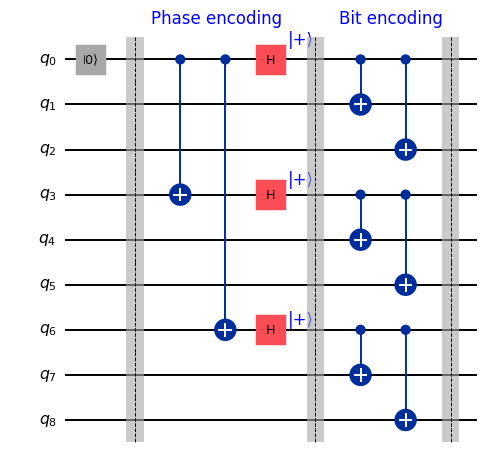

In [362]:
qc = encode_shor_code()
fig = qc.draw(output='mpl', scale = 0.7,idle_wires=False)
ax = fig.axes[0]
ax.text(0.3, 1.0, 'Phase encoding', transform=ax.transAxes, fontsize=12, color='blue')
ax.text(0.7, 1.0, 'Bit encoding', transform=ax.transAxes, fontsize=12, color='blue')

ax.text(0.59, 0.62+.33, '|+⟩', transform=ax.transAxes, fontsize=12, color='blue')
ax.text(0.59, 0.62, '|+⟩', transform=ax.transAxes, fontsize=12, color='blue')
ax.text(0.59, 0.62-.33, '|+⟩', transform=ax.transAxes, fontsize=12, color='blue')

display(fig)

## 1. Phase encoding

Encode qubit 0 into qubit 3 and qubit 6 in X basis:

$|0_0⟩ → |0_0⟩|0_3⟩|0_6⟩ → |+_0⟩|+_3⟩|+_6⟩$

similarly

$|1_0⟩ → |1_0⟩|1_3⟩|1_6⟩ → |-_0⟩|-_3⟩|-_6⟩$

> These are not necessarily entangled if the inputs are |0⟩ or |1⟩ as shown.

It is important to note that all we have done is add a Hadamard gate AFTER 3 bit repetitiion code encoding to make it a phase encoding...


## 2. Concatenate the bit code on top:

We're starting with $|0_0⟩ → |0_0⟩|0_3⟩|0_6⟩ → |+_0⟩|+_3⟩|+_6⟩$

Consider just the first 'block' qubit 0.

### Encode Block 1 (qubit 0)

1. CNOT qubit 0 to qubit 1:  $|+_0⟩ → \frac{1}{\sqrt{2}}[|0_0 0_1⟩+|1_0 1_1⟩]$

1. CNOT qubit 1 to qubit 2: $\frac{1}{\sqrt{2}}[|0_0 0_1⟩+|1_0 1_1⟩]→ \frac{1}{\sqrt{2}}[|0_0 0_1 0_2⟩+|1_0 1_1 1_2⟩]$

    Now we have encoded 'block 1' from qubit 0 into qubit 1 and qubit 2.

    $|+_0⟩ → \frac{1}{\sqrt{2}}[|0_0 0_1 0_2⟩+|1_0 1_1 1_2⟩]$

### Encode Block 2 (qubit 3)

$|+_3⟩ → \frac{1}{\sqrt{2}}[|0_3 0_4 0_5⟩+|1_3 1_4 1_5⟩]$

### Encode Block 2 (qubit 6)

$|+_6⟩ → \frac{1}{\sqrt{2}}[|0_6 0_7 0_8⟩+|1_6 1_7 1_8⟩]$



## Full concatenated 9 qubit Shor encoding:

$\large |0⟩ → \frac{|0_0 0_3 0_6⟩ + |1_0 1_3 1_6⟩}{\sqrt{2}} → \frac{|0_0 0_1 0_2⟩ + |1_0 1_1 1_2⟩}{\sqrt{2}} \frac{|0_30_40_5⟩ + |1_31_41_5⟩}{\sqrt{2}} \frac{|0_60_70_8⟩ + |1_61_71_8⟩}{\sqrt{2}} = |0⟩_L$


Similarly:

$\large |1⟩ → \frac{|0_0 0_3 0_6⟩ - |1_0 1_3 1_6⟩}{\sqrt{2}} → \frac{|0_0 0_1 0_2⟩ - |1_0 1_1 1_2⟩}{\sqrt{2}} \frac{|0_30_40_5⟩ - |1_31_41_5⟩}{\sqrt{2}} \frac{|0_60_70_8⟩ - |1_61_71_8⟩}{\sqrt{2}} = |1⟩_L$



## 9 qubit code Syndromes:

In [363]:
def apply_random_errors_shor(qc, p_bit=0.1, p_phase=0.1):
    """Apply random bit and phase flip errors to the Shor code circuit
    
    Args:
        qc (QuantumCircuit): Circuit to apply errors to
        p_bit (float): Probability of bit flip on each qubit
        p_phase (float): Probability of phase flip on each qubit
    """
    for i in range(9):  # For each data qubit
        if np.random.random() < p_bit:
            qc.x(i)  # Bit flip
        if np.random.random() < p_phase:
            qc.z(i)  # Phase flip
    return qc

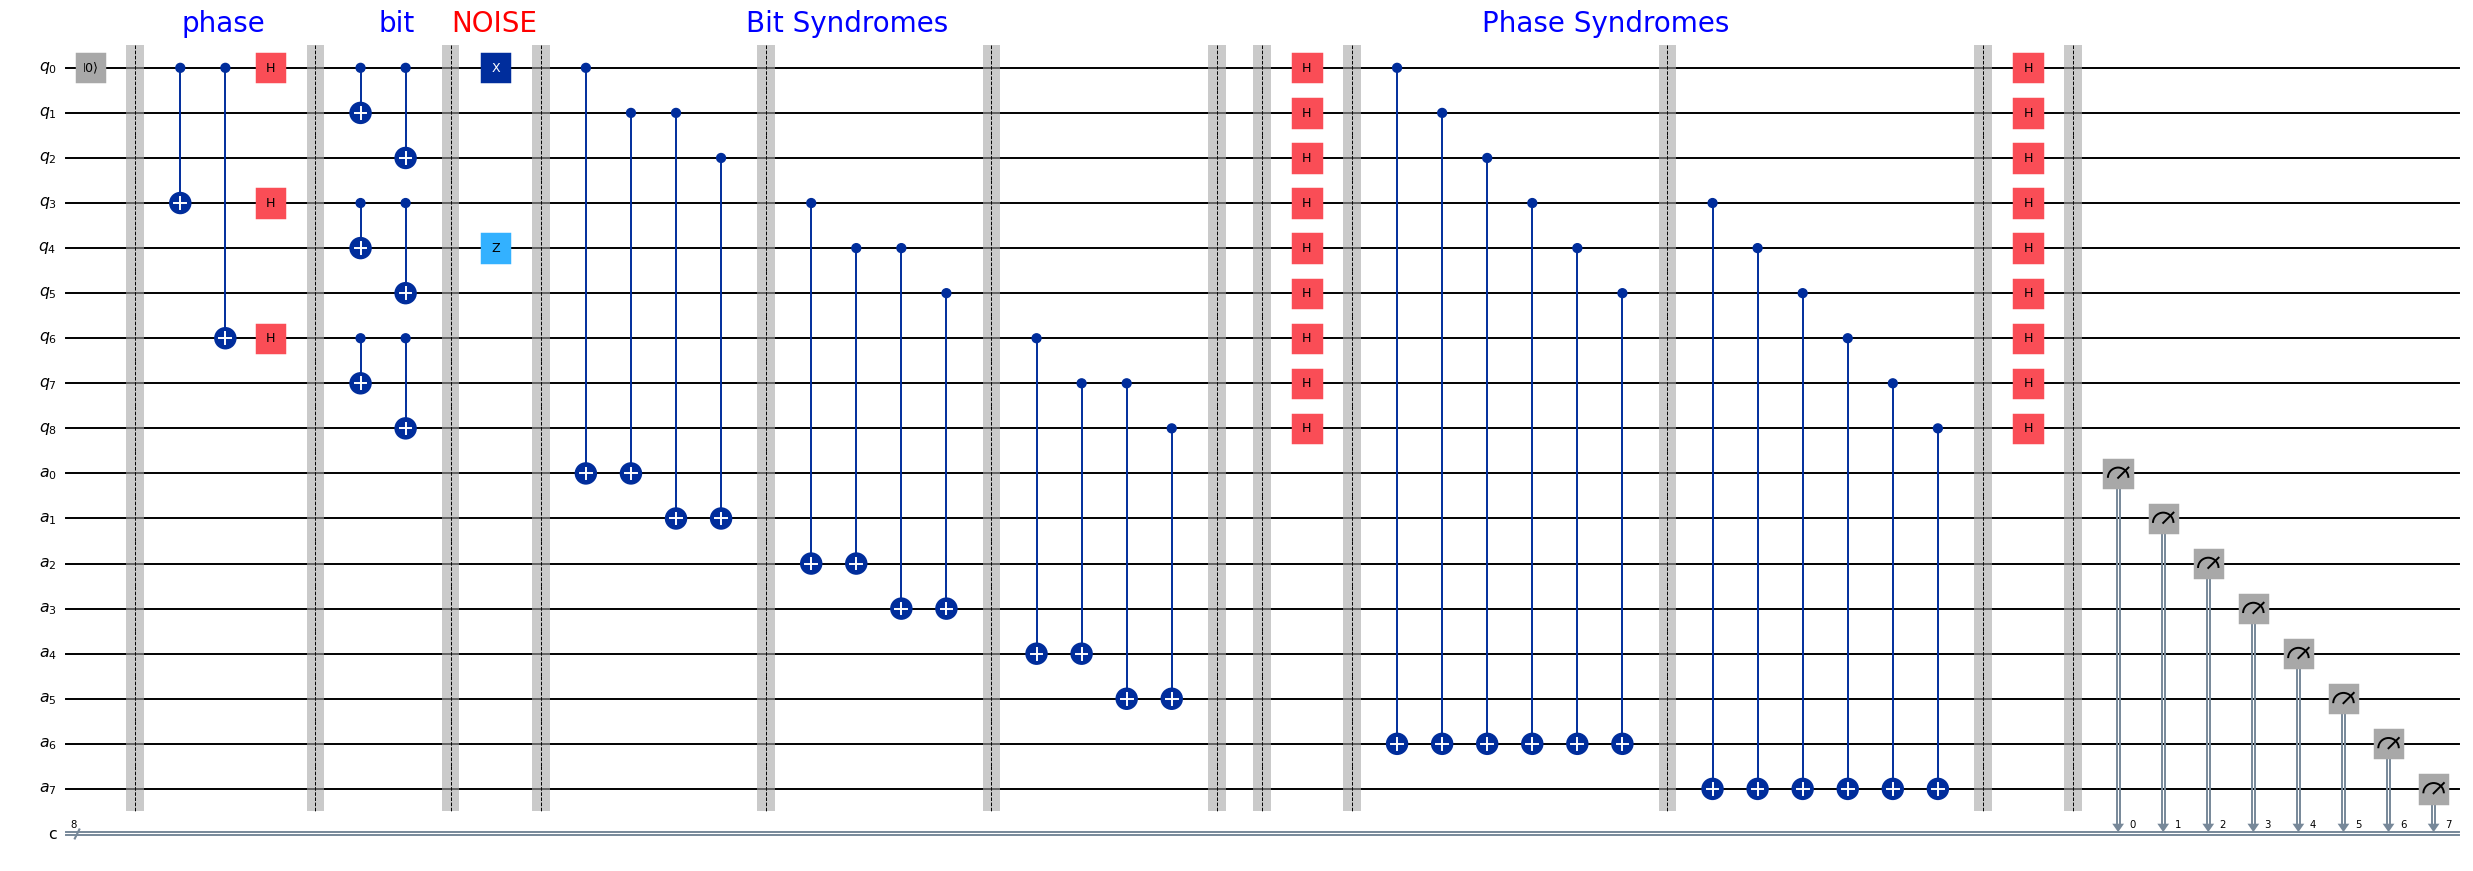

In [365]:
def shor_add_bit_syndrome_measurement(qc, aux, with_barriers=True):
    """Add Bit Flip syndrome measurement to Shor code"""

    # Bit flip Syndrome measurements
    for block in [0, 3, 6]:  # For each block of 3 qubits
        # ZZ measurement between first and second qubit
        qc.cx(block, aux[block//3*2])
        qc.cx(block+1, aux[block//3*2])

        # ZZ measurement between second and third qubit
        qc.cx(block+1, aux[block//3*2+1])
        qc.cx(block+2, aux[block//3*2+1])

        if with_barriers:
            qc.barrier()
        
    if with_barriers:
        qc.barrier()

    return qc

def shor_add_phase_syndrome_measurement(qc, aux, with_barriers=True):
    """Add Phase syndrome measurement to Shor code"""

    # Phase flip syndromes (between blocks)
    # (Convert Z errors to X errors)
    for qubit in range(0,9):
        qc.h(qubit)

    if with_barriers:
        qc.barrier()

    # Compare first and second block
    qc.cx(0, aux[6])
    qc.cx(1, aux[6])
    qc.cx(2, aux[6])

    qc.cx(3, aux[6])
    qc.cx(4, aux[6])
    qc.cx(5, aux[6])
    
    if with_barriers:
        qc.barrier()

    # Compare second and third block
    qc.cx(3, aux[7])  
    qc.cx(4, aux[7])  
    qc.cx(5, aux[7])  

    qc.cx(6, aux[7])
    qc.cx(7, aux[7])
    qc.cx(8, aux[7])
    
    if with_barriers:
        qc.barrier()

    for qubit in range(0,9):
        qc.h(qubit)

    if with_barriers:
        qc.barrier()

    return qc


def create_shor_code_with_syndromes(p_bit=0.1, p_phase=0.1, with_barriers=True, add_error=True, bit_syn=True, phase_syn = True, encode=True):
    """Create the 9-qubit Shor code circuit with syndrome measurements"""
    # Main registers
    qr = QuantumRegister(9, 'q')  # 9 data qubits
    aux = QuantumRegister(8, 'a')  # 8 auxillary qubits for syndrome measurements
    cr = ClassicalRegister(8, 'c')  # 8 classical bits for syndrome results
    qc = QuantumCircuit(qr, aux, cr)
    
    if encode:
        qc = encode_shor_code()

    '''
    Add random errors
    '''
    if add_error:
        qc = apply_random_errors_shor(qc, p_bit=p_bit, p_phase=p_phase)
    if with_barriers:
        qc.barrier()
    
    if bit_syn:
        '''Add Bit Flip Syndromes'''
        qc = shor_add_bit_syndrome_measurement(qc, aux, with_barriers)

    if phase_syn:
        '''Add Phase Flip Syndromes'''
        qc = shor_add_phase_syndrome_measurement(qc, aux, with_barriers)

    '''Measure all auxillary to get syndromes'''
    qc.measure(aux, cr)
    
    return qc

qc = create_shor_code_with_syndromes(p_bit=0.10, p_phase=0.10)
# qc.draw('mpl',scale=0.4 ,fold = 100)

fig = qc.draw(output='mpl', scale = 0.7,fold = 100)

ax = fig.axes[0]
fs=20
ax.text(0.07, 1.0, 'phase', transform=ax.transAxes, fontsize=fs, color='blue')
ax.text(0.15, 1.0, 'bit', transform=ax.transAxes, fontsize=fs, color='blue')
ax.text(0.18, 1.0, 'NOISE', transform=ax.transAxes, fontsize=fs, color='red')
ax.text(0.3, 1.0, 'Bit Syndromes', transform=ax.transAxes, fontsize=fs, color='blue')
ax.text(0.6, 1.0, 'Phase Syndromes', transform=ax.transAxes, fontsize=fs, color='blue')
display(fig)


## Syndrome Truth Table for the Shor Code

The syndrome measurements use 8 auxillary qubits total:
- 6 auxillary qubits for bit flip detection  $\rightarrow 0_{a0}0_{a1}~0_{a2}0_{a3}~0_{a4}0_{a5}$

- 2 auxillary qubits for phase flip detection  $\rightarrow 0_{a6}0_{a7}$


## 6 auxillary qubits for bit flip detection

| Error | Bit flip Syndrome | Description |
|-------|----------|-------------|
| -  | 01 23 45 | qubit ordering |
| I  | 00 00 00 | No error |
| X1 | 10 00 00 | Bit-flip in qubit 1 |
| X2 | 11 00 00 | Bit-flip in qubit 2 |
| X3 | 01 00 00 | Bit-flip in qubit 3 |
| X4 | 00 10 00 | Bit-flip in qubit 4 |
| X5 | 00 11 00 | Bit-flip in qubit 5 |
| X6 | 00 01 00 | Bit-flip in qubit 6 |
| X7 | 00 00 10 | Bit-flip in qubit 7 |
| X8 | 00 00 11 | Bit-flip in qubit 8 |
| X9 | 00 00 01 | Bit-flip in qubit 9 |

## 2 auxillary qubits for phase flip detection

| Error | Phase flip Syndrome | Description |
|-------|----------|-------------|
| Z123 | 10 | Phase-flip in qubit 1,2,3 |
| Z456 | 11 | Phase-flip in qubit 4,5,6 |
| Z789 | 01 | Phase-flip in qubit 7,8,9 |


## All together the full syndrome of the 8 auxillary qubits is:


| Error | Full Syndrome | Description |
|-------|----------|-------------|
| -  | 01 23 45 67 | qubit order |
| I  | 00 00 00 00 | No error |
| X0 | 10 00 00 00 | Bit-flip in qubit 0 |
| X1 | 11 00 00 00 | Bit-flip in qubit 1 |
| X2 | 01 00 00 00 | Bit-flip in qubit 2 |
| X3 | 00 10 00 00 | Bit-flip in qubit 3 |
| X4 | 00 11 00 00 | Bit-flip in qubit 4 |
| X5 | 00 01 00 00 | Bit-flip in qubit 5 |
| X6 | 00 00 10 00 | Bit-flip in qubit 6 |
| X7 | 00 00 11 00 | Bit-flip in qubit 7 |
| X8 | 00 00 01 00 | Bit-flip in qubit 8 |
| Z012 | 00 00 00 10 | Phase-flip in qubit 0,1,2 |
| Z345 | 00 00 00 11 | Phase-flip in qubit 3,4,5 |
| Z678 | 00 00 00 01 | Phase-flip in qubit 6,7,8 |


# 9 qubit Shor Code with a bit flip and a phase flip

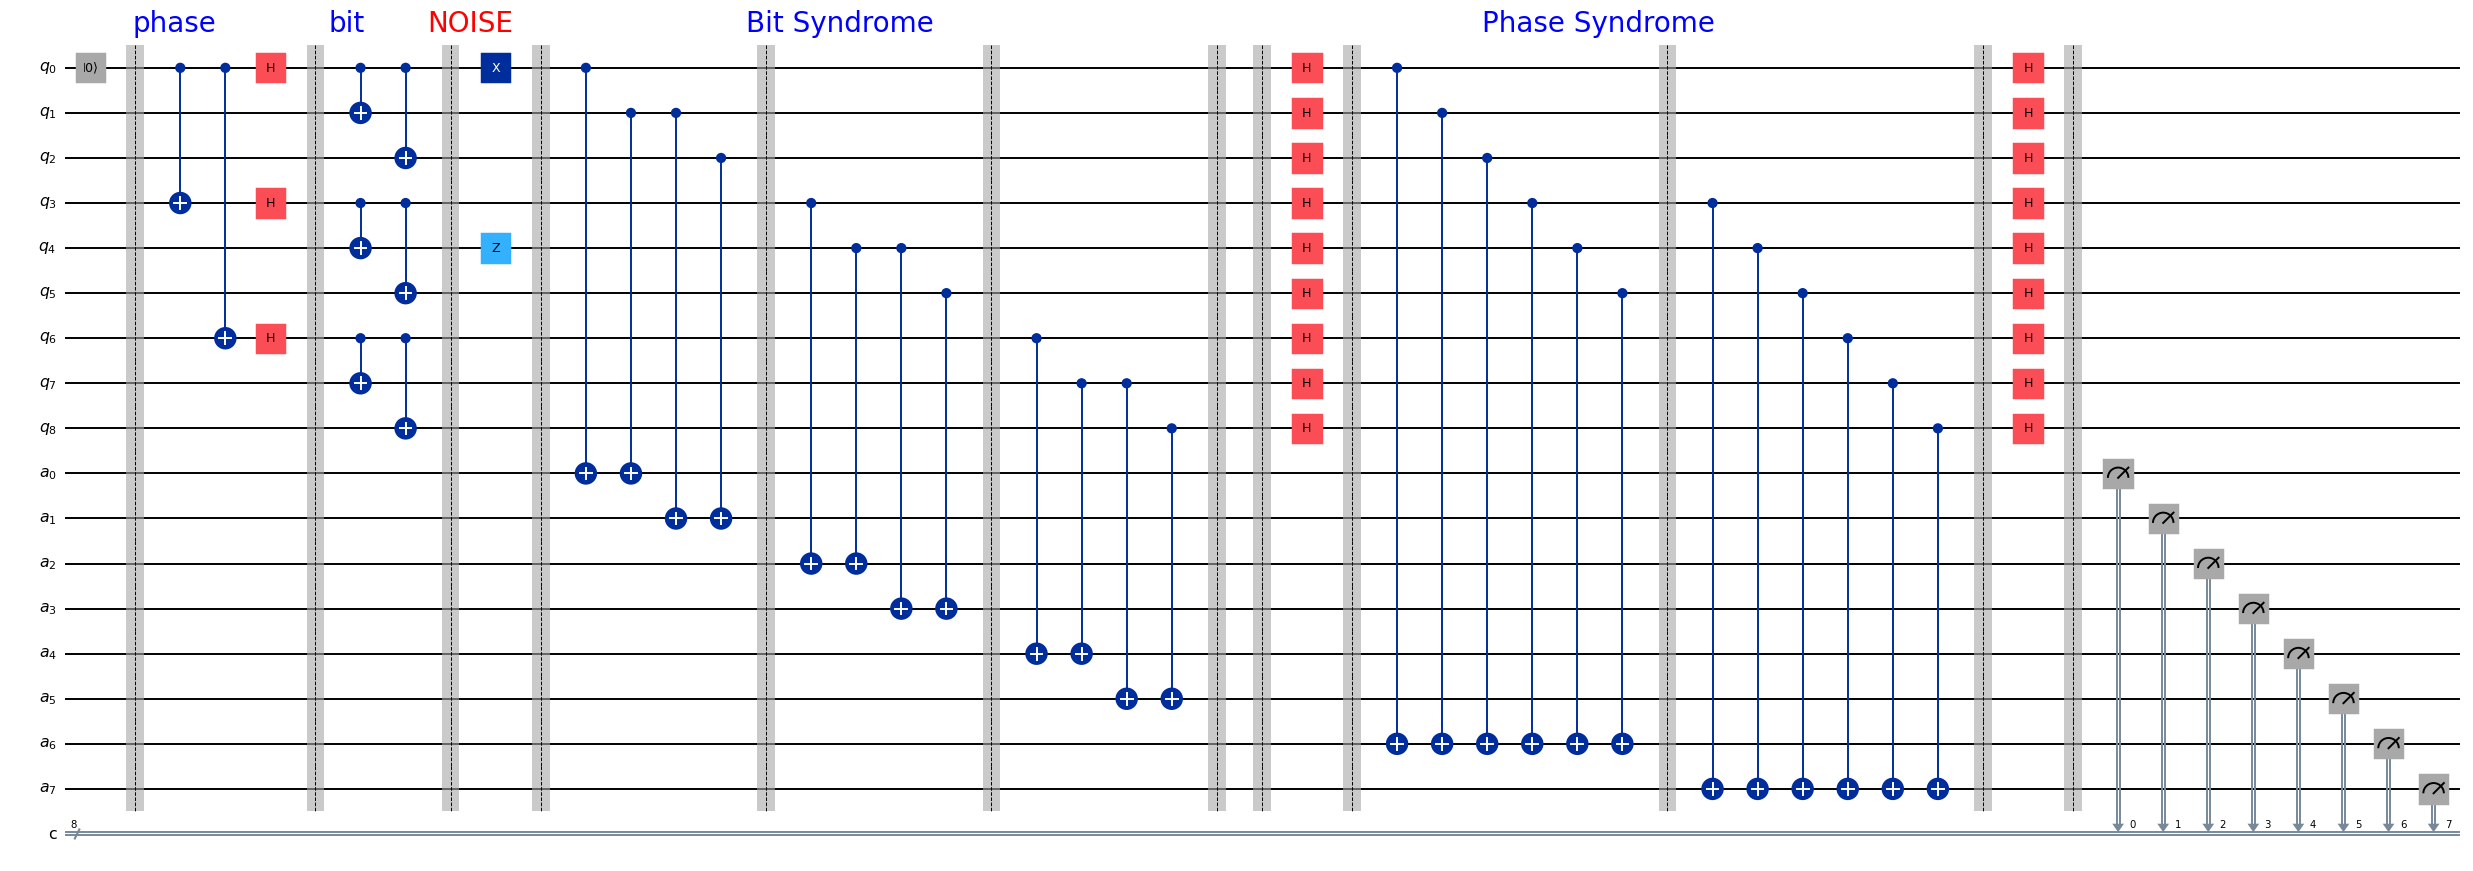

In [366]:
# run until you get 1 bit flip and 1 phase flip error!

fig = qc.draw(output='mpl', scale = 0.7,fold = 100)
ax = fig.axes[0]
fs=20
ax.text(0.05, 1.0, 'phase', transform=ax.transAxes, fontsize=fs, color='blue')
ax.text(0.13, 1.0, 'bit', transform=ax.transAxes, fontsize=fs, color='blue')
ax.text(0.17, 1.0, 'NOISE', transform=ax.transAxes, fontsize=fs, color='red')
ax.text(0.3, 1.0, 'Bit Syndrome', transform=ax.transAxes, fontsize=fs, color='blue')
ax.text(0.6, 1.0, 'Phase Syndrome', transform=ax.transAxes, fontsize=fs, color='blue')
display(fig)

In [368]:
counts = ideal_sim(qc, shots=100)
print(counts)
# plot_histogram(counts)

{'11000001': 100}


## Decode Syndrome

In [369]:
def decode_syndrome(counts):
    """
    Decodes the syndrome measurement from Shor code simulation results.
    
    Args:
        counts (dict): Results from quantum circuit measurement
        
    Returns:
        tuple: (bit_error_msg, phase_error_msg) containing decoded error messages
    """
    # Get the measured syndrome from counts
    syndrome = list(counts.keys())[0] 
    print(f"Measured full syndrome (Qiskit order '876543210' ): {syndrome}")

    # Reverse the qubit bit order
    reversed_syndrome = syndrome[::-1]
    print(f"Reversed full syndrome (bit order '012345678'): {reversed_syndrome}")

    # Split syndrome into bit and phase parts
    bit_syndrome = reversed_syndrome[:6]  # First 6 bits for X errors
    phase_syndrome = reversed_syndrome[-2:] # Last 2 bits for Z errors
    print(f"Bit syndrome (first 6 bits): {bit_syndrome}")
    print(f"Phase syndrome (last 2 bits): {phase_syndrome}")

    # Create syndrome lookup tables
    bit_error_lookup = {
        '000000': 'No bit-flip error',
        '100000': 'Bit-flip on qubit 0',
        '110000': 'Bit-flip on qubit 1', 
        '010000': 'Bit-flip on qubit 2',
        '001000': 'Bit-flip on qubit 3',
        '001100': 'Bit-flip on qubit 4',
        '000100': 'Bit-flip on qubit 5',
        '000010': 'Bit-flip on qubit 6',
        '000011': 'Bit-flip on qubit 7',
        '000001': 'Bit-flip on qubit 8'
    }

    phase_error_lookup = {
        '00': 'No phase-flip error',
        '10': 'Phase-flip on qubits 0,1,2',
        '11': 'Phase-flip on qubits 3,4,5', 
        '01': 'Phase-flip on qubits 6,7,8'
    }

    # Look up the errors
    bit_error = bit_error_lookup.get(bit_syndrome, "Unknown bit error pattern")
    phase_error = phase_error_lookup.get(phase_syndrome, "Unknown phase error pattern")
    
    print('\n Results: \n')
    print("Bit error:", bit_error)
    print("Phase error:", phase_error)
    
    return bit_error, phase_error


In [370]:
# Decode the syndrome from the simulation results
bit_result, phase_result = decode_syndrome(counts)

Measured full syndrome (Qiskit order '876543210' ): 11000001
Reversed full syndrome (bit order '012345678'): 10000011
Bit syndrome (first 6 bits): 100000
Phase syndrome (last 2 bits): 11

 Results: 

Bit error: Bit-flip on qubit 0
Phase error: Phase-flip on qubits 3,4,5


This verifies that the decoder is working properly and performing the proper bit string reversal!

## Ideal simulation (with bit and phase flips added)

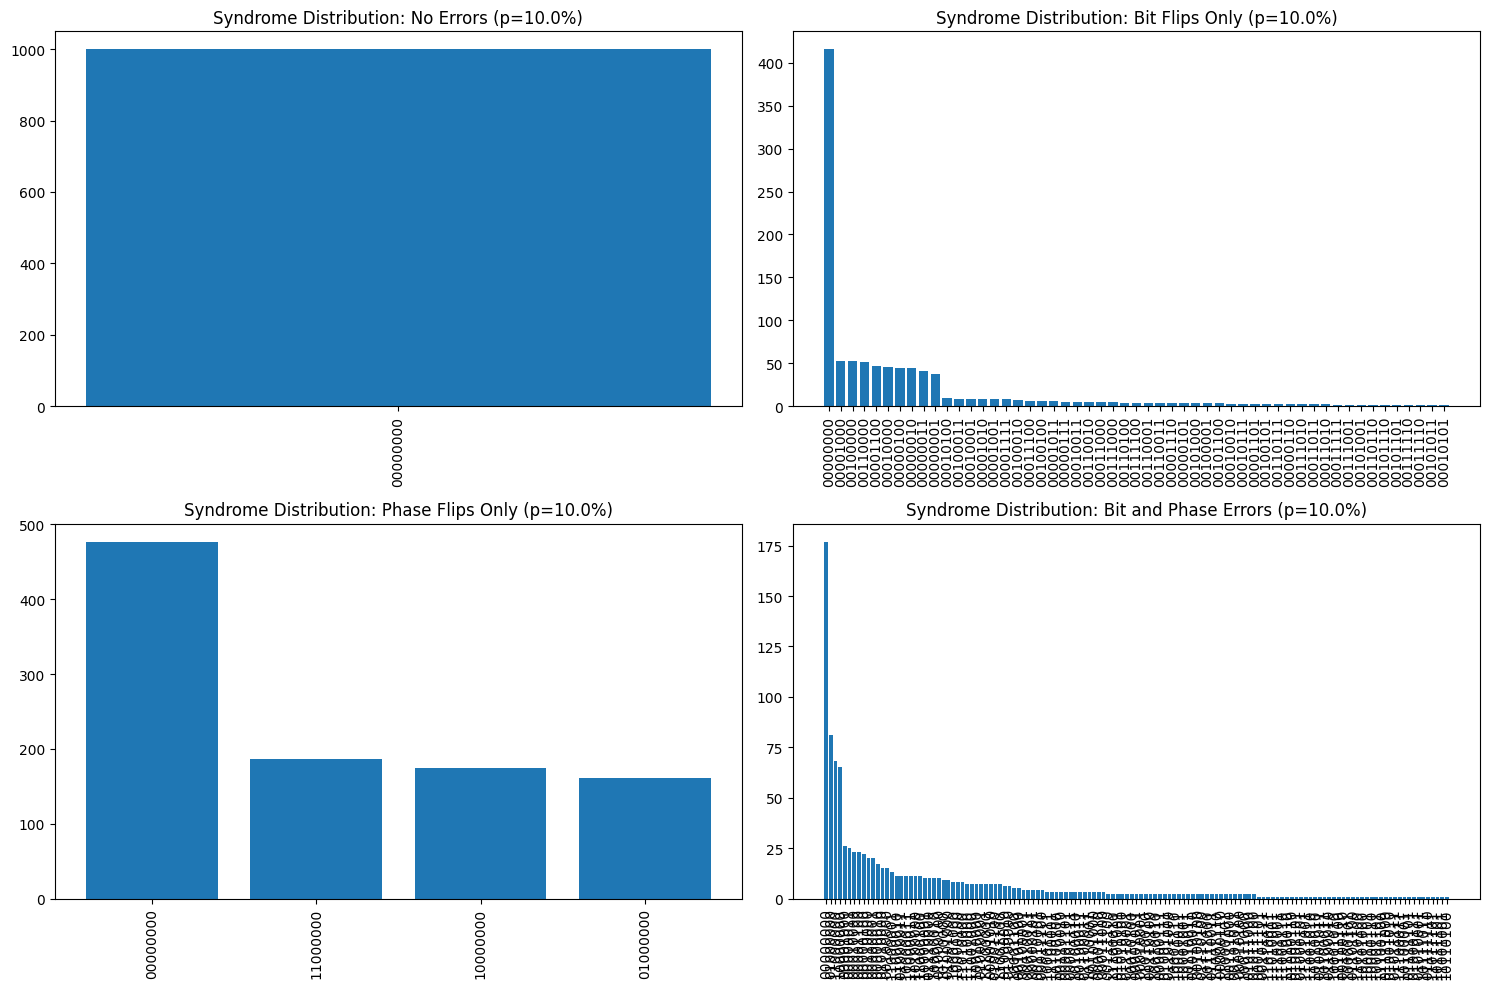

In [309]:
p_error = 0.1

# Run demonstration with different error scenarios
scenarios = [
    (0.0, 0.0, "No Errors"),
    (p_error, 0.0, "Bit Flips Only"),
    (0.0, p_error, "Phase Flips Only"),
    (p_error, p_error, "Bit and Phase Errors")
]

# Plot results for each scenario
plt.figure(figsize=(15, 10))
for i, (p_bit, p_phase, title) in enumerate(scenarios, 1):
    plt.subplot(2, 2, i)

    counts = {}
    trials = arange(1000)
    for trial in trials: 
        counts = combine_counts(counts, ideal_sim(create_shor_code_with_syndromes(p_bit=p_bit, p_phase=p_phase),shots=1))

    plt.bar(sorted(counts.keys(), key=lambda x: counts[x], reverse=True), [counts[k] for k in sorted(counts.keys(), key=lambda x: counts[x], reverse=True)])
    plt.xticks(rotation=90)

    plt.title(f"Syndrome Distribution: {title} (p={p_error*100}%)")

plt.tight_layout()
plt.show()


## Multiple bit flip errors detected AND phase flips detected *simultaneously*!

One big advantage of the Shor code is that multiple bit flips can be detected simultaneously and bit flips with phase flips can also be detected simultaneously IF the phase flips are on different blocks. 

Here we see in the bit flip distribution that the first set of errors are the single bit flip errors, but double bit flips are seen also at a lower probability. 

We also see that phase flips and bit flips are detected simultenously in the final distrubition allowing both as well.

## Simulate Shor QEC on *noisy* fake QPU

## First test just the phase syndromes

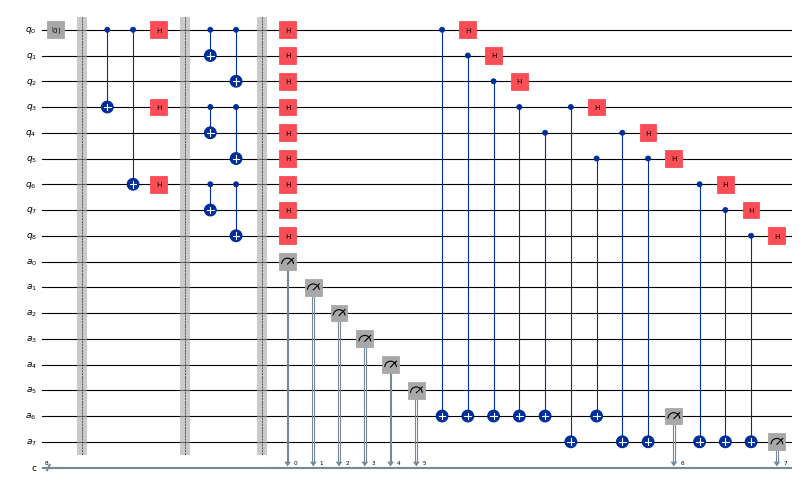

In [134]:
qc = create_shor_code_with_syndromes(p_bit=0.0, p_phase=0.00, with_barriers=False, add_error=False, phase_syn=True, bit_syn=False, encode=True)
qc.draw('mpl',scale=0.4 ,fold = 100)

{'01000000': 88, '00000000': 755, '00000010': 2, '10000000': 106, '11000000': 32, '00010000': 5, '00000100': 7, '01000010': 1, '11000010': 2, '10000100': 1, '00000001': 1}

Most likely outcome: 00000000 occurred 755 times (75.5% of shots)


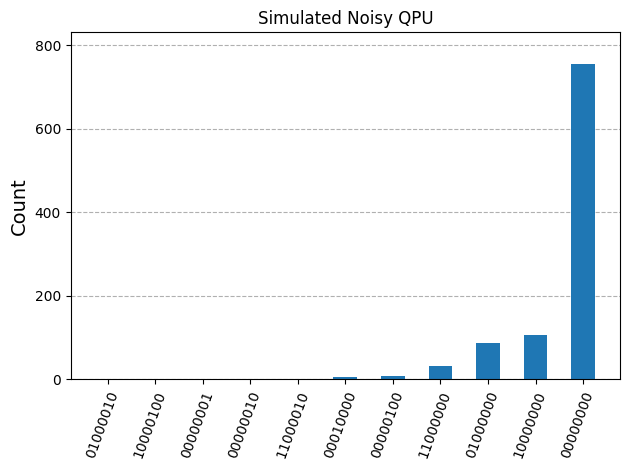

In [137]:
counts = backend_sim(qc)

print(counts)
# Find the most frequent outcome
most_likely = max(counts.items(), key=lambda x: x[1])
print(f"\nMost likely outcome: {most_likely[0]} occurred {most_likely[1]} times ({(most_likely[1]/1000)*100:.1f}% of shots)")

plot_histogram(counts,title='Simulated Noisy QPU' , sort = 'value', bar_labels=False)

## Decode errors and bin by syndrome

In [146]:
def analyze_error_syndromes(counts, total_shots=1000):
    # Define known single-qubit error syndromes
    bit_error_lookup = {
        '000000': 'No bit-flip error',
        '100000': 'Bit-flip on qubit 0',
        '110000': 'Bit-flip on qubit 1', 
        '010000': 'Bit-flip on qubit 2',
        '001000': 'Bit-flip on qubit 3',
        '001100': 'Bit-flip on qubit 4',
        '000100': 'Bit-flip on qubit 5',
        '000010': 'Bit-flip on qubit 6',
        '000011': 'Bit-flip on qubit 7',
        '000001': 'Bit-flip on qubit 8'
    }

    phase_error_lookup = {
        '00': 'No phase-flip error',
        '10': 'Phase-flip on qubits 0–2',
        '11': 'Phase-flip on qubits 3–5', 
        '01': 'Phase-flip on qubits 6–8'
    }

    # Add entries for multi-qubit/unknown errors
    bit_error_lookup['other'] = 'Other bit-flip errors'
    phase_error_lookup['other'] = 'Other phase-flip errors'

    # Initialize syndrome counters
    bit_error_specifics = {syndrome: 0 for syndrome in bit_error_lookup}
    phase_error_specifics = {syndrome: 0 for syndrome in phase_error_lookup}

    # Reverse the bit strings in counts
    reversed_counts = {key[::-1]: value for key, value in counts.items()}

    # Count occurrences
    for syndrome, count in reversed_counts.items():
        bit_syndrome = syndrome[:6]
        phase_syndrome = syndrome[-2:]

        if bit_syndrome in bit_error_specifics:
            bit_error_specifics[bit_syndrome] += count
        else:
            bit_error_specifics['other'] += count

        if phase_syndrome in phase_error_specifics:
            phase_error_specifics[phase_syndrome] += count
        else:
            phase_error_specifics['other'] += count

    # Print analysis
    print("\nBit-flip Error Analysis:")
    for syndrome, description in bit_error_lookup.items():
        count = bit_error_specifics.get(syndrome, 0)
        probability = (count / total_shots) * 100
        print(f"{description}: {count} ({probability:.1f}%)")

    print("\nPhase-flip Error Analysis:")
    for syndrome, description in phase_error_lookup.items():
        count = phase_error_specifics.get(syndrome, 0)
        probability = (count / total_shots) * 100
        print(f"{description}: {count} ({probability:.1f}%)")

    # Plot results
    plt.figure(figsize=(8, 8))

    # Bit-flip bar plot
    plt.subplot(2, 1, 1)
    plt.bar(bit_error_lookup.values(), [bit_error_specifics[k] for k in bit_error_lookup])
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Counts')
    plt.title('Bit-flip Error Distribution')

    # Phase-flip bar plot
    plt.subplot(2, 1, 2)
    plt.bar(phase_error_lookup.values(), [phase_error_specifics[k] for k in phase_error_lookup])
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Counts')
    plt.title('Phase-flip Error Distribution')

    plt.tight_layout()
    plt.show()


Bit-flip Error Analysis:
No bit-flip error: 981 (98.1%)
Bit-flip on qubit 0: 1 (0.1%)
Bit-flip on qubit 1: 0 (0.0%)
Bit-flip on qubit 2: 5 (0.5%)
Bit-flip on qubit 3: 8 (0.8%)
Bit-flip on qubit 4: 0 (0.0%)
Bit-flip on qubit 5: 0 (0.0%)
Bit-flip on qubit 6: 5 (0.5%)
Bit-flip on qubit 7: 0 (0.0%)
Bit-flip on qubit 8: 0 (0.0%)
Other bit-flip errors: 0 (0.0%)

Phase-flip Error Analysis:
No phase-flip error: 770 (77.0%)
Phase-flip on qubits 0–2: 89 (8.9%)
Phase-flip on qubits 3–5: 34 (3.4%)
Phase-flip on qubits 6–8: 107 (10.7%)
Other phase-flip errors: 0 (0.0%)


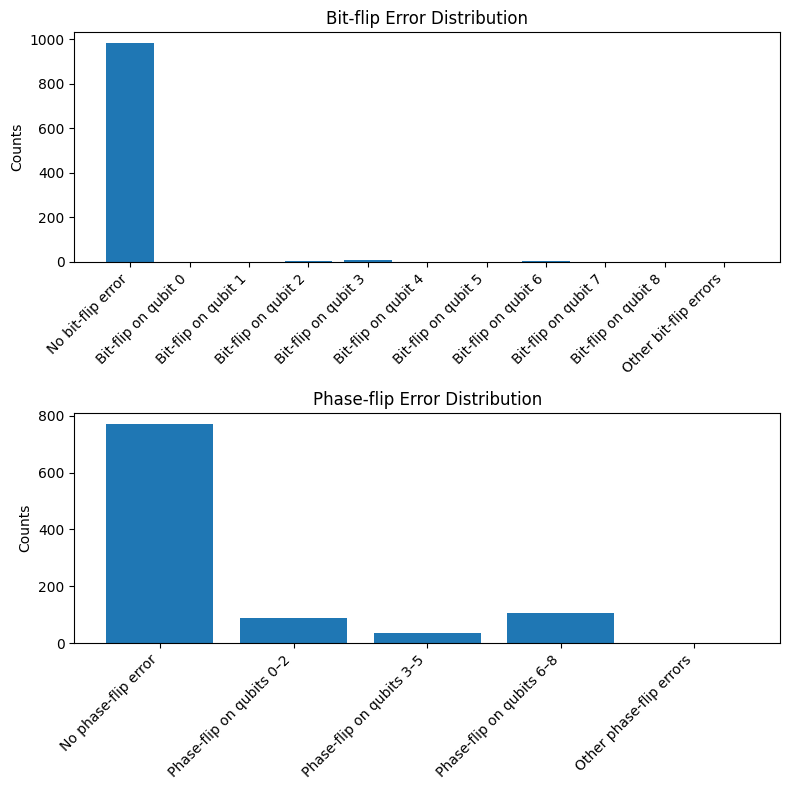

In [147]:
analyze_error_syndromes(counts)

In [150]:
print(ideal_sim(qc)) #verify with noiseless simulation

{'00000000': 100}


## Bit syndromes

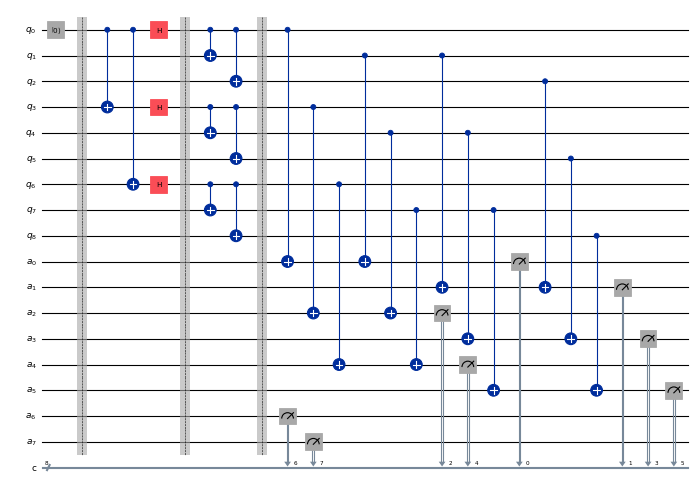

In [149]:
qc = create_shor_code_with_syndromes(p_bit=0.0, p_phase=0.00, with_barriers=False, add_error=False, phase_syn=False, bit_syn=True, encode=True)
qc.draw('mpl',scale=0.4 ,fold = 100)

{'00100000': 26, '00001000': 77, '00000000': 691, '00110011': 1, '00000100': 15, '00011000': 7, '00010000': 27, '01000100': 1, '00101011': 1, '00000010': 42, '00000111': 1, '00110000': 14, '00101010': 1, '00000001': 26, '00000011': 22, '00001100': 19, '00100010': 1, '00001011': 3, '00110010': 2, '01000000': 3, '10000000': 1, '00001001': 2, '00010011': 2, '00010100': 3, '00001110': 2, '00001010': 6, '00101000': 2, '00100100': 1, '00111000': 1}

Most likely outcome: 00000000 occurred 691 times (69.1% of shots)


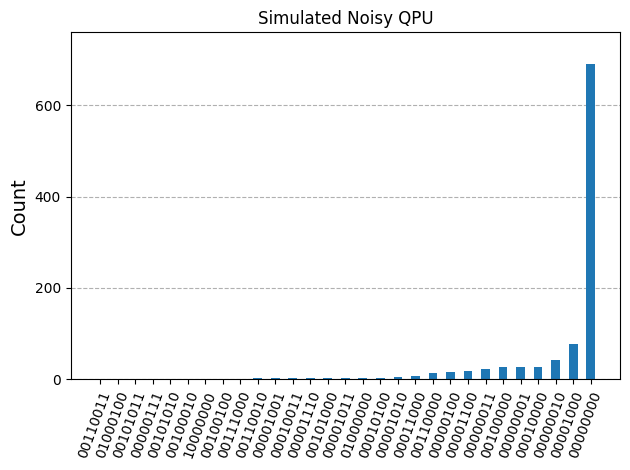

In [151]:
counts = backend_sim(qc)
print(counts)

most_likely = max(counts.items(), key=lambda x: x[1])# Find the most frequent outcome
print(f"\nMost likely outcome: {most_likely[0]} occurred {most_likely[1]} times ({(most_likely[1]/1000)*100:.1f}% of shots)")

plot_histogram(counts,title='Simulated Noisy QPU' , sort = 'value', bar_labels=False)


Bit-flip Error Analysis:
No bit-flip error: 695 (69.5%)
Bit-flip on qubit 0: 26 (2.6%)
Bit-flip on qubit 1: 22 (2.2%)
Bit-flip on qubit 2: 42 (4.2%)
Bit-flip on qubit 3: 16 (1.6%)
Bit-flip on qubit 4: 19 (1.9%)
Bit-flip on qubit 5: 77 (7.7%)
Bit-flip on qubit 6: 27 (2.7%)
Bit-flip on qubit 7: 14 (1.4%)
Bit-flip on qubit 8: 26 (2.6%)
Other bit-flip errors: 36 (3.6%)

Phase-flip Error Analysis:
No phase-flip error: 995 (99.5%)
Phase-flip on qubits 0–2: 4 (0.4%)
Phase-flip on qubits 3–5: 0 (0.0%)
Phase-flip on qubits 6–8: 1 (0.1%)
Other phase-flip errors: 0 (0.0%)


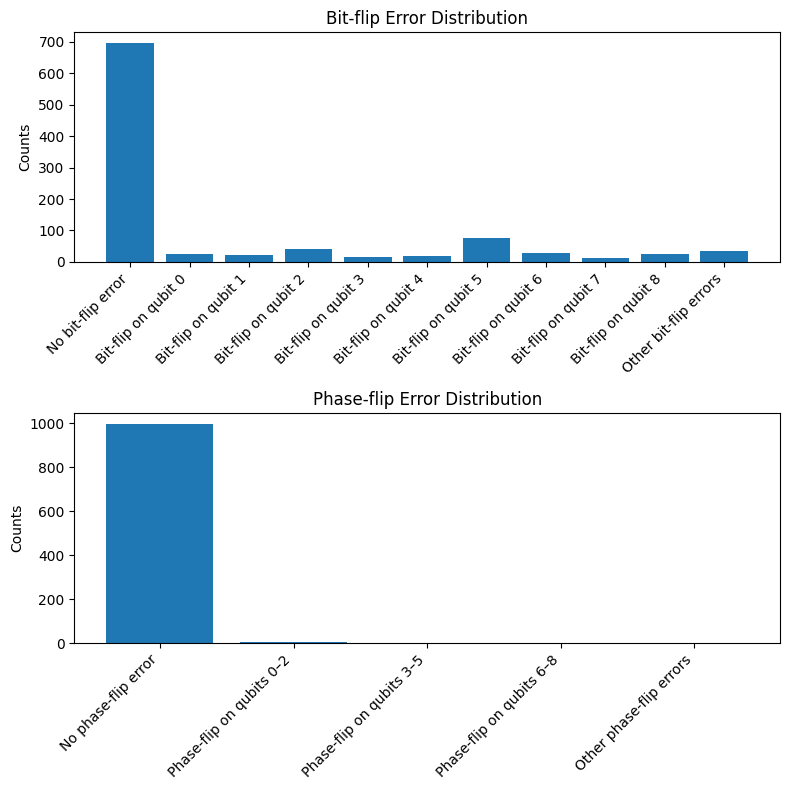

In [152]:
analyze_error_syndromes(counts)

## Phase and Bit Syndromes on a simulated noisy QPU

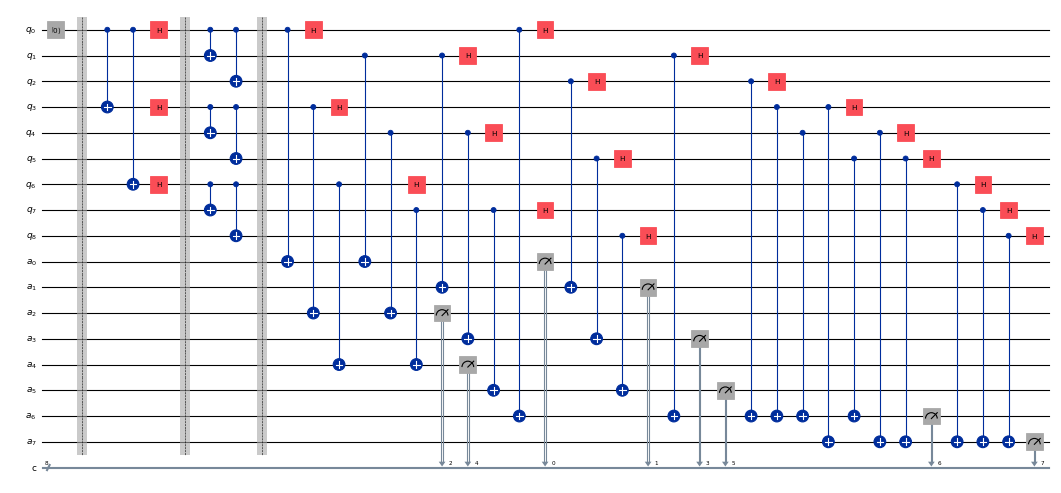

In [153]:
qc = create_shor_code_with_syndromes(p_bit=0.0, p_phase=0.00, with_barriers=False, add_error=False, phase_syn=True, bit_syn=True, encode=True)
qc.draw('mpl',scale=0.4 ,fold = 100)

{'11001110': 1, '01000100': 13, '00000010': 21, '10000000': 58, '00100000': 24, '01000110': 1, '10101001': 1, '00000000': 433, '00100001': 3, '10010000': 3, '11001100': 9, '11100001': 1, '00000100': 49, '01000010': 21, '01010000': 3, '00100100': 3, '11000011': 2, '00001000': 15, '10100001': 3, '10100000': 12, '11001001': 1, '11011000': 1, '11000000': 35, '01000000': 66, '01100000': 6, '11001000': 9, '11110000': 1, '10101100': 2, '10000100': 9, '01000001': 5, '00110000': 7, '10001000': 2, '11100000': 4, '01000011': 12, '01110000': 1, '11000100': 7, '00100011': 1, '00001100': 14, '01000111': 1, '00000001': 28, '01001000': 6, '00001110': 1, '01001100': 2, '11000010': 2, '00010010': 3, '00100010': 3, '11000101': 1, '00101000': 4, '01100011': 1, '00000011': 13, '10000001': 6, '11110010': 1, '10000101': 1, '10110000': 2, '01010010': 2, '00010000': 24, '01010011': 2, '10100010': 1, '10111000': 1, '10100100': 1, '11111000': 1, '10011000': 1, '10110001': 2, '11000001': 1, '11101100': 3, '011000

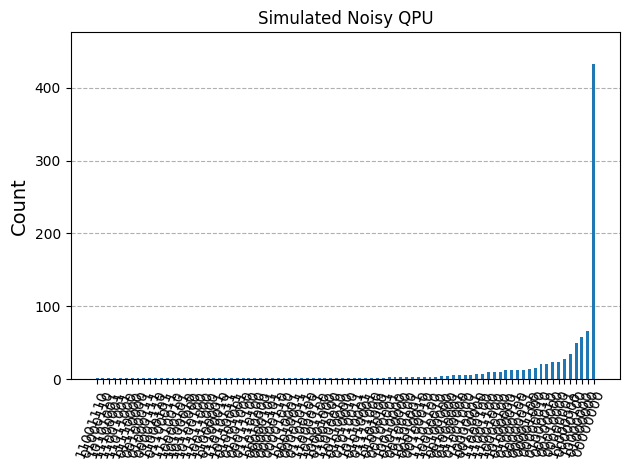

In [154]:
counts = backend_sim(qc)
print(counts)

most_likely = max(counts.items(), key=lambda x: x[1])# Find the most frequent outcome
print(f"\nMost likely outcome: {most_likely[0]} occurred {most_likely[1]} times ({(most_likely[1]/1000)*100:.1f}% of shots)")

plot_histogram(counts,title='Simulated Noisy QPU' , sort = 'value', bar_labels=False)


Bit-flip Error Analysis:
No bit-flip error: 592 (59.2%)
Bit-flip on qubit 0: 40 (4.0%)
Bit-flip on qubit 1: 27 (2.7%)
Bit-flip on qubit 2: 47 (4.7%)
Bit-flip on qubit 3: 78 (7.8%)
Bit-flip on qubit 4: 25 (2.5%)
Bit-flip on qubit 5: 32 (3.2%)
Bit-flip on qubit 6: 31 (3.1%)
Bit-flip on qubit 7: 11 (1.1%)
Bit-flip on qubit 8: 46 (4.6%)
Other bit-flip errors: 71 (7.1%)

Phase-flip Error Analysis:
No phase-flip error: 653 (65.3%)
Phase-flip on qubits 0–2: 153 (15.3%)
Phase-flip on qubits 3–5: 85 (8.5%)
Phase-flip on qubits 6–8: 109 (10.9%)
Other phase-flip errors: 0 (0.0%)


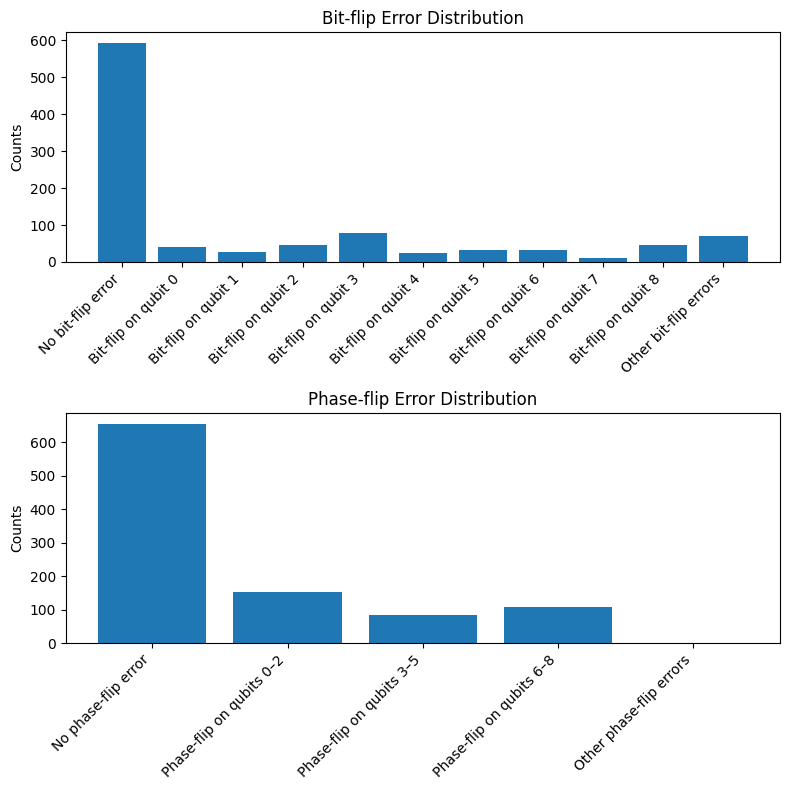

In [155]:
analyze_error_syndromes(counts)

# Run full Shor Code on a real QPU

### Test with a circuit that only encodes the logical qubit (no syndromes) first to verify readout etc.

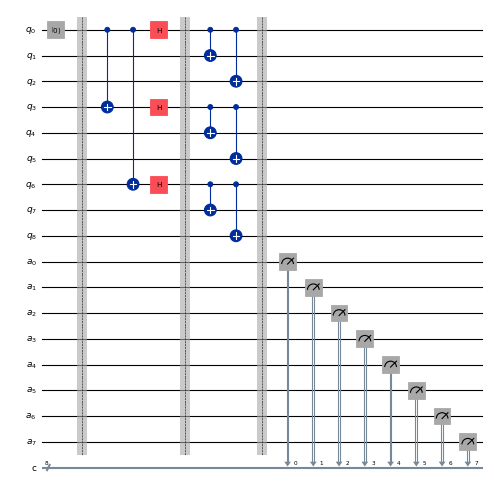

In [156]:
qc = create_shor_code_with_syndromes(p_bit=0.0, p_phase=0.00, with_barriers=False, add_error=False, phase_syn=False, bit_syn=False, encode=True)
qc.draw('mpl',scale=0.4 ,fold = 100)

<IBMBackend('ibm_kyiv')>
{'00000000': 988, '10000000': 1, '00010000': 5, '01000000': 1, '00001000': 1, '00000001': 2, '00000010': 1, '00100000': 1}


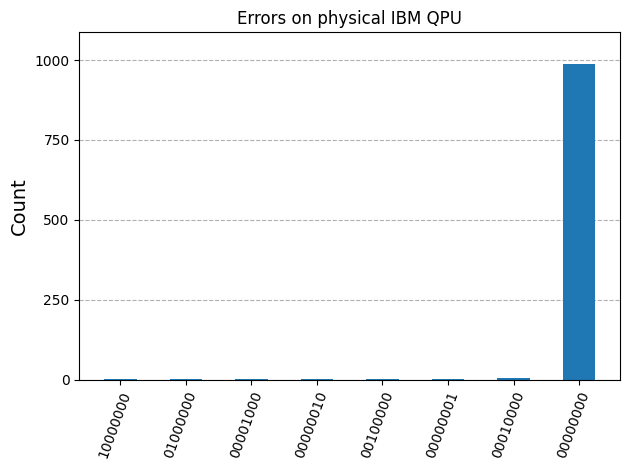

In [ ]:
counts = backend_real(qc)
print(counts)
plot_histogram(counts,title='Errors on physical IBM QPU',bar_labels=False,sort='value')

Excellent. We have confirmed the encoding circuit 'works' in that if no syndrome is added, the auxillary qubits just read zeros.
It was possible that readout error would have prevented even this without verifying.

## Add the bit syndrome measurements and run on real QPU

> Notice we omit barriers in the circuit as they can cause undue delays in the circuit and measurements that degrade performance.

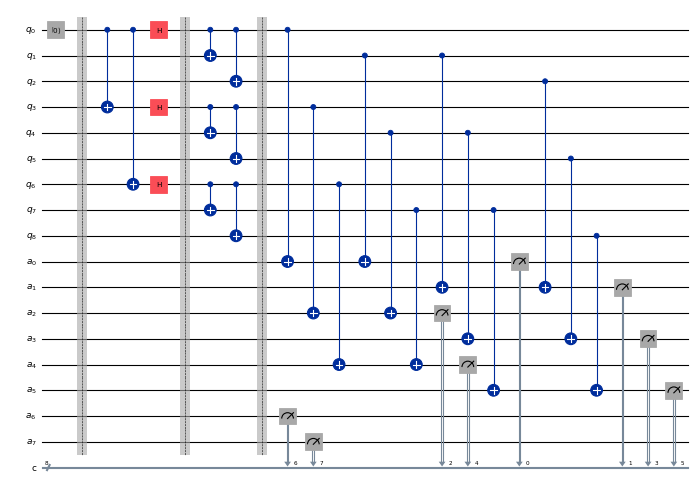

In [247]:
qc = create_shor_code_with_syndromes(p_bit=0.0, p_phase=0.00, with_barriers=False, add_error=False, phase_syn=False, bit_syn=True, encode=True)
qc.draw('mpl',scale=0.4 ,fold = 100)

<IBMBackend('ibm_sherbrooke')>
{'00101001': 1, '00000100': 25, '00000111': 2, '00000110': 3, '00000000': 485, '00110000': 57, '00001000': 65, '00100001': 2, '00001100': 57, '00000010': 71, '00001010': 9, '00001110': 5, '00100000': 60, '00010000': 33, '00101000': 3, '00000001': 24, '00111010': 2, '00110001': 2, '00000101': 2, '00100100': 2, '00100010': 8, '00111000': 5, '00000011': 22, '01110010': 1, '00110010': 7, '00011100': 3, '00010001': 7, '00110011': 1, '00010010': 2, '01000000': 2, '00001001': 2, '00111100': 5, '00101100': 3, '00111110': 2, '00001111': 5, '00100110': 1, '00010110': 2, '00001101': 1, '00011000': 4, '00100011': 1, '00010100': 1, '00011010': 1, '10000010': 1, '00001011': 1, '01001110': 1, '01000010': 1}


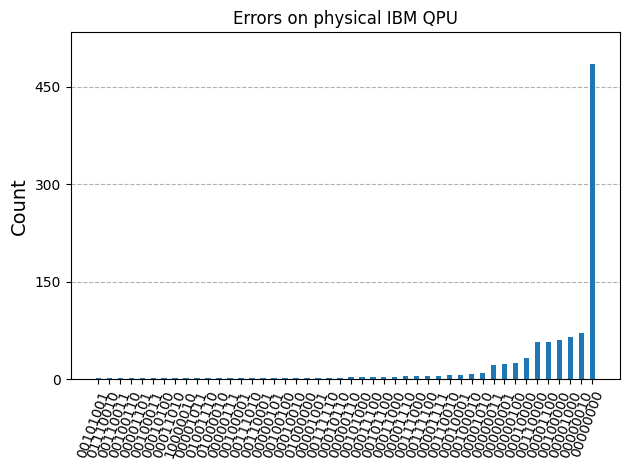

In [248]:
counts = backend_real(qc)

print(counts)
plot_histogram(counts,title='Errors on physical IBM QPU',bar_labels=False,sort='value')


Bit-flip Error Analysis:
No bit-flip error: 487 (48.7%)
Bit-flip on qubit 0: 24 (2.4%)
Bit-flip on qubit 1: 22 (2.2%)
Bit-flip on qubit 2: 73 (7.3%)
Bit-flip on qubit 3: 25 (2.5%)
Bit-flip on qubit 4: 57 (5.7%)
Bit-flip on qubit 5: 65 (6.5%)
Bit-flip on qubit 6: 33 (3.3%)
Bit-flip on qubit 7: 57 (5.7%)
Bit-flip on qubit 8: 60 (6.0%)
Other bit-flip errors: 97 (9.7%)

Phase-flip Error Analysis:
No phase-flip error: 994 (99.4%)
Phase-flip on qubits 0–2: 5 (0.5%)
Phase-flip on qubits 3–5: 0 (0.0%)
Phase-flip on qubits 6–8: 1 (0.1%)
Other phase-flip errors: 0 (0.0%)


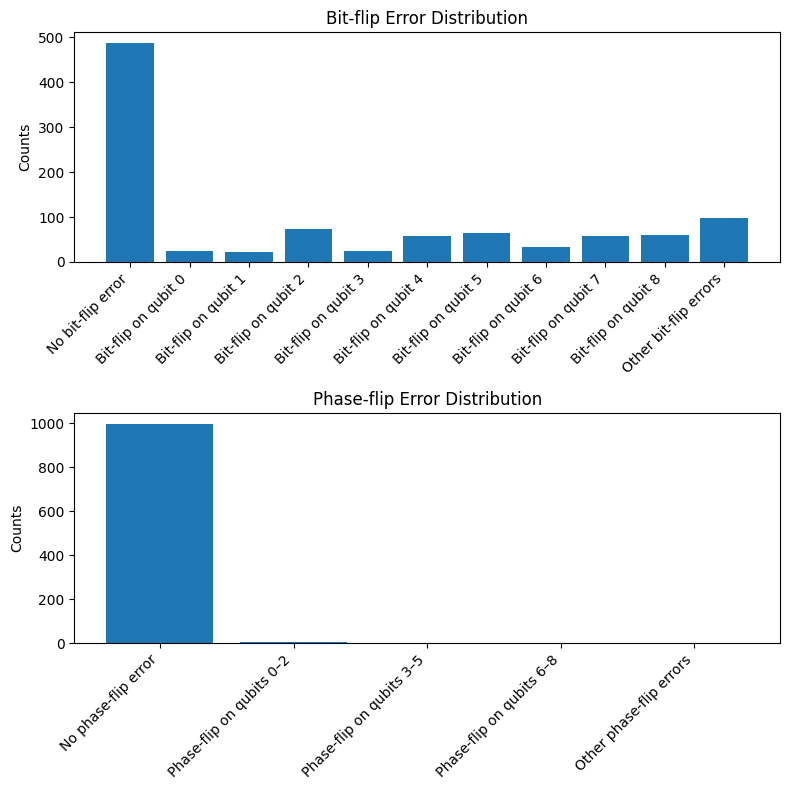

In [249]:
analyze_error_syndromes(counts)

### Excellent! The most likely output is 'no bit flip'!

We also see that almost no phase flips are seen as we're not adding syndromes for phase errors.

That suggests the results are accurate.

## Phase syndrome on real QPU

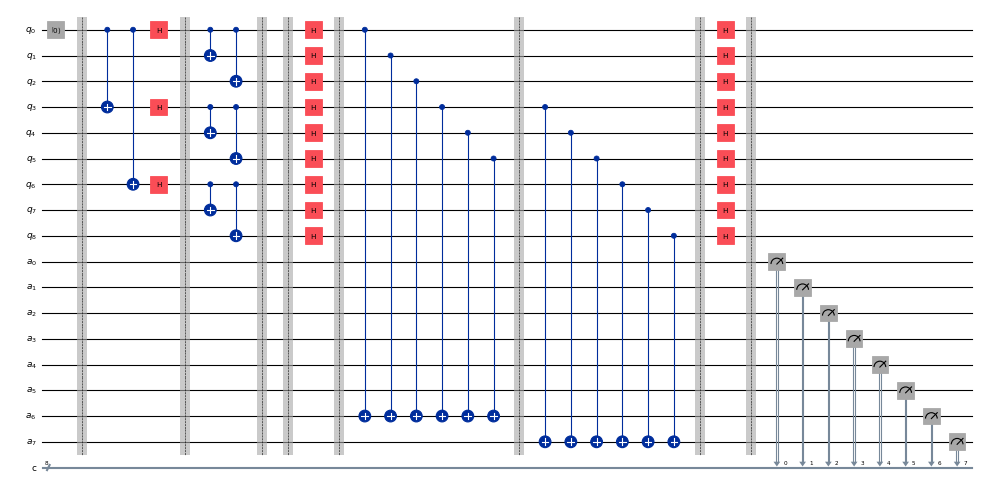

In [236]:
# qc = create_shor_code_with_syndromes(p_bit=0.0, p_phase=0.00, with_barriers=True, add_error=False, phase_syn=True, bit_syn=False, encode=True)
# qc.draw('mpl',scale=0.4 ,fold = 100)
qc = create_shor_code_with_syndromes(p_bit=0.0, p_phase=0.00, with_barriers=True, add_error=False, phase_syn=True, bit_syn=False, encode=True)
qc.draw('mpl',scale=0.4 ,fold = 100)

In [237]:
print(ideal_sim(qc))

{'00000000': 100}


{'00001000': 1, '00000000': 718, '01000100': 1, '00000010': 4, '10000000': 149, '01000000': 80, '11000000': 34, '01100000': 1, '00010000': 2, '11000100': 1, '01000010': 1, '00000100': 8}


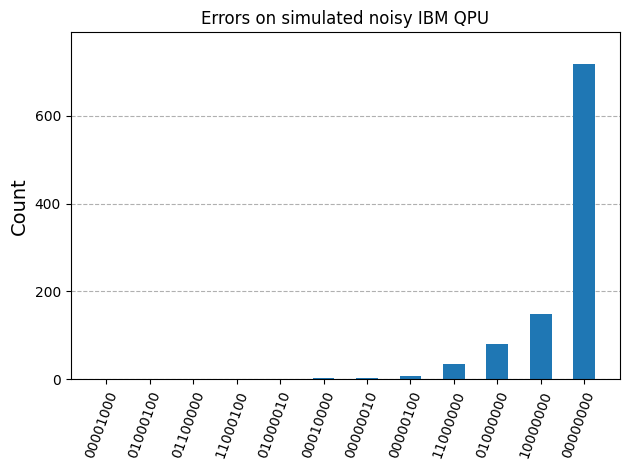

In [238]:
counts = backend_sim(qc)
print(counts)
plot_histogram(counts,title='Errors on simulated noisy IBM QPU',bar_labels=False,sort='value')

<IBMBackend('ibm_sherbrooke')>
{'01000000': 236, '11000000': 251, '10000000': 249, '00000000': 236, '11010000': 1, '00100000': 2, '01000001': 3, '01000100': 4, '11100000': 2, '00001000': 2, '10000100': 3, '10010000': 1, '00010000': 2, '10001000': 1, '10000010': 2, '01100000': 2, '01000010': 1, '00000100': 1, '11000100': 1}


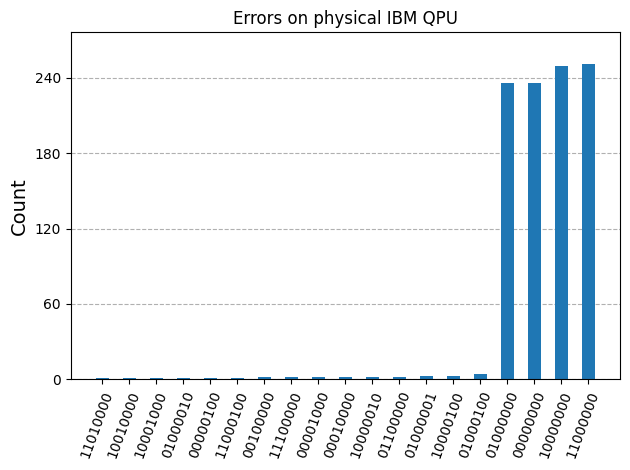

In [184]:
counts = backend_real(qc, optimization_level=2)

print(counts)
plot_histogram(counts,title='Errors on physical IBM QPU',bar_labels=False,sort='value')

## Hmm.. that looks like just noise... Maybe we can change the circuit a little to improve the results.

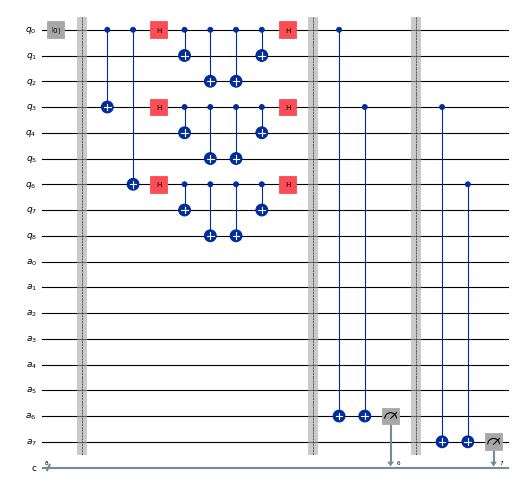

In [240]:
qr = QuantumRegister(9, 'q')  # 9 data qubits
aux = QuantumRegister(8, 'a')  # 8 auxillary qubits for syndrome measurements
cr = ClassicalRegister(8, 'c')  # 8 classical bits for syndrome results

qc = QuantumCircuit(qr, aux, cr)

qc = encode_shor_code(with_barriers=False)

# Unencode the phase encoding by applying operations in reverse
for i in [0, 3, 6]:
    qc.cx(i, i+2)
    qc.cx(i, i+1)
    qc.h(i)


qc.barrier()

"""Add Phase syndrome measurements to Shor code"""


# Compare first and second block
qc.cx(0, aux[6])
qc.cx(3, aux[6])

qc.measure(aux[6], cr[6])

qc.barrier()

# Compare second and third block
qc.cx(3, aux[7])  
qc.cx(6, aux[7])

qc.measure(aux[7], cr[7])

qc.draw('mpl',scale=0.4 ,fold = 100)

### Un-encoding

We've un-encoded the phase encoding so that the measurements only need to probe one qubit for each block.

This is cheating... and basically defeats the purpose... but will compile (and transpile away some gates) and run with few errors... 🙂

{'00000000': 933, '01000000': 22, '10000000': 31, '11000000': 14}


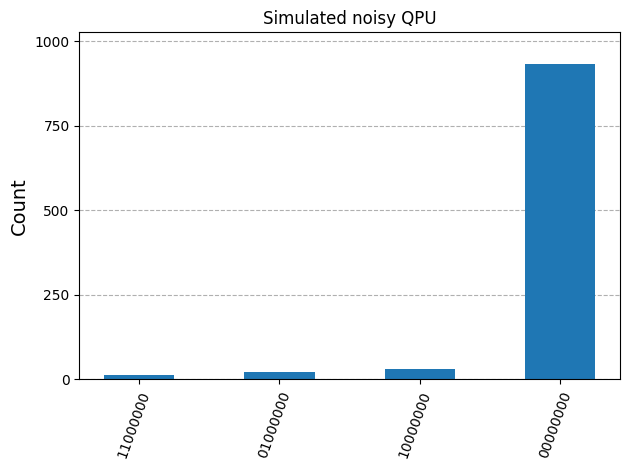

In [241]:
counts = backend_sim(qc)
print(counts)

plot_histogram(counts,title='Simulated noisy QPU' , sort = 'value', bar_labels=False)

<IBMBackend('ibm_sherbrooke')>
{'10000000': 100, '00000000': 788, '01000000': 67, '11000000': 45}


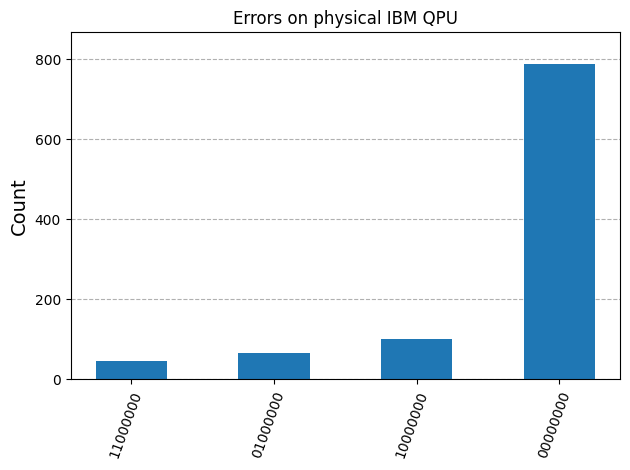

In [242]:
counts = backend_real(qc)
print(counts)
plot_histogram(counts,title='Errors on physical IBM QPU',bar_labels=False,sort='value')

# Error Correction

In [1113]:
noise_model = NoiseModel()

def create_error_correction_circuit(error_prob=0.2, apply_correction=True, delay=False, identity_gates=False, xgates=False):
    # Create a quantum circuit with 3 data qubits and 2 auxiliary qubits for syndrome measurement
    n_qubits = 3
    n_aux = 2
    cr = ClassicalRegister(n_qubits + n_aux,'c')
    qr = QuantumRegister(n_qubits + n_aux,'q')
    qc = QuantumCircuit(qr, cr)

    # Encode logical |0⟩ state into 3-qubit code
    qc.cx(qr[0], qr[1])
    qc.cx(qr[0], qr[2])

    qc.barrier()

    if delay == True:
        # Add delays between encoding and error to simulate decoherence
        qc.delay(100, qr[0])
        qc.delay(100, qr[1]) 
        qc.delay(100, qr[2])

        qc.barrier()
    
    if identity_gates == True:
        # Add idenity gates between encoding and error to simulate decoherence
        qc.id(qr[0])
        qc.id(qr[1]) 
        qc.id(qr[2])

        qc.barrier()

    if xgates == True:
        # Add idenity gates between encoding and error to simulate decoherence
        qc.x(qr[0])
        qc.x(qr[1]) 
        qc.x(qr[2])
        qc.barrier()
        qc.x(qr[0])
        qc.x(qr[1]) 
        qc.x(qr[2])
        qc.barrier()

    # Add a random error with given probability on each qubit
    import random
    for i in range(3):
        if random.random() < error_prob:
            qc.x(qr[i])

    qc.barrier()

    # Measure syndrome using auxiliary qubits
    qc.cx(qr[0], qr[3])
    qc.cx(qr[1], qr[3])
    qc.cx(qr[1], qr[4])
    qc.cx(qr[2], qr[4])

    qc.barrier()
    # Measure aux
    qc.measure(qr[3], cr[3])
    qc.measure(qr[4], cr[4])

    qc.barrier()

    if apply_correction:
        # Apply corrections based on syndrome
        with qc.if_test((cr[4], 0)):
            with qc.if_test((cr[3], 1)):
                qc.x(qr[0])

        with qc.if_test((cr[4], 1)):
            with qc.if_test((cr[3], 1)):
                qc.x(qr[1])

        with qc.if_test((cr[4], 1)):
            with qc.if_test((cr[3], 0)):
                qc.x(qr[2])

    qc.barrier()
    # Measure data qubits
    qc.measure(qr[0], cr[0])
    qc.measure(qr[1], cr[1])
    qc.measure(qr[2], cr[2])
    
    return qc

## Correcting errors detected by the syndromes

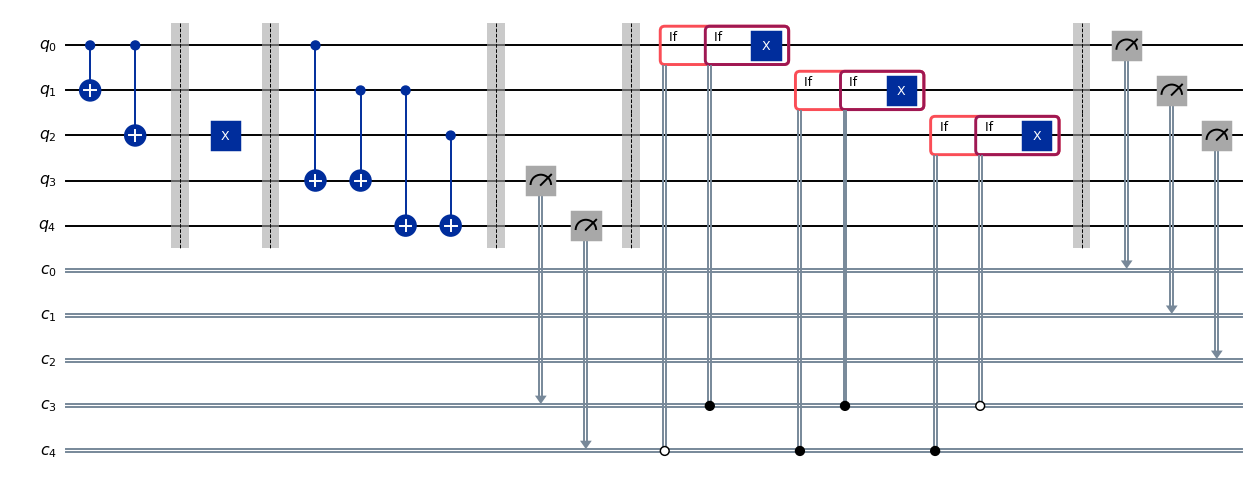

In [1117]:
qc = create_error_correction_circuit(error_prob=0.3, apply_correction=True)
qc.draw('mpl',scale= 0.7,cregbundle=False, fold = 50)

## Circuit has random memory errors (post encoding) that the correction fixes

In [1118]:
noise_model = NoiseModel()
shots=1000
counts = ideal_sim(qc,shots=shots)
print(counts)

{'10000': 1000}


In [1119]:
def analyze_error_detection(counts, shots, plot_title='Error Correction Analysis', show_plot=False):

    # Reverse string of counts and decode
    reversed_counts = {k[::-1]: v for k, v in counts.items()}

    last_two_counts = {}
    for bitstring, count in reversed_counts.items():
        last_two = bitstring[-2:]  # Get the last 2 bits (least significant)
        last_two_counts[last_two] = last_two_counts.get(last_two, 0) + count

    reversed_counts = last_two_counts
    print(reversed_counts)

    try:
        no_error = reversed_counts['00']/shots * 100
    except KeyError:
        no_error = 0
    try:
        q0_error = reversed_counts['10']/shots * 100
    except KeyError:
        q0_error = 0
    try:
        q1_error = reversed_counts['11']/shots * 100
    except KeyError:
        q1_error = 0
    try:
        q2_error = reversed_counts['01']/shots * 100
    except KeyError:
        q2_error = 0

    print(f"Error Analysis:")
    print(f"No error (00): {no_error:.2f}%")
    print(f"Q0 error (10): {q0_error:.2f}%")
    print(f"Q1 error (11): {q1_error:.2f}%")
    print(f"Q2 error (01): {q2_error:.2f}%") 

    if show_plot:
        display(plot_histogram(reversed_counts, title=plot_title, sort='value', bar_labels=False))
    
    return {
        'no_error': no_error,
        'q0_error': q0_error,
        'q1_error': q1_error,
        'q2_error': q2_error
    }

In [1120]:
def analyze_error_correction(counts, shots, plot_title='Error Correction Analysis', show_plot=False):

    # Reverse string of counts and decode
    reversed_counts = {k[::-1]: v for k, v in counts.items()}

    # Group by all 3 bits to check majority
    bit_counts = {}
    for bitstring, count in reversed_counts.items():
        three_bits = bitstring[:-2]  # Get the 3 data bits
        bit_counts[three_bits] = bit_counts.get(three_bits, 0) + count

    # Analyze all 3 bits in the register
    print(bit_counts)

    # Calculate percentages for each bit pattern
    total = sum(bit_counts.values())
    percentages = {}
    for bitstring, count in bit_counts.items():
        percentages[bitstring] = (count/shots) * 100

    # Count majority of bits for logical value
    logical_0_count = 0
    logical_1_count = 0
    for bitstring, count in bit_counts.items():
        # Count number of 1s in bitstring using list comprehension and sum
        num_ones = sum([int(bit) for bit in bitstring])
        if num_ones < len(bitstring)/2:  # Majority 0s
            logical_0_count += count
        else:  # Majority 1s
            logical_1_count += count

    logical_0_percent = (logical_0_count/shots) * 100
    logical_1_percent = (logical_1_count/shots) * 100

    print(f"\n LOGICAL Error Analysis:")
    print(f"Logical bit (by majority):")
    print(f"  Logical 0: {logical_0_percent:.2f}%")
    print(f"  Logical 1: {logical_1_percent:.2f}%")
    print(f"\nRaw measurements:")
    for bitstring, percentage in percentages.items():
        print(f"{bitstring}: {percentage:.2f}%")

    if show_plot:
        display(plot_histogram(bit_counts, title=plot_title, sort='value', bar_labels=False))
    
    return {
        'percentages': percentages,
        'logical_results': {
            'logical_0': logical_0_percent,
            'logical_1': logical_1_percent
        }
    }

In [1121]:
errors_detected = analyze_error_detection(counts, shots)
logical_error = analyze_error_correction(counts, shots)

{'01': 1000}
Error Analysis:
No error (00): 0.00%
Q0 error (10): 0.00%
Q1 error (11): 0.00%
Q2 error (01): 100.00%
{'000': 1000}

 LOGICAL Error Analysis:
Logical bit (by majority):
  Logical 0: 100.00%
  Logical 1: 0.00%

Raw measurements:
000: 100.00%


Without noise the error correction is working perfectly!

Let's add some noise and see what happens...

## Test error detection and correction on a Fake QPU

We have added an error and we want to see if the syndrome is detecting it and if we can then correct it.

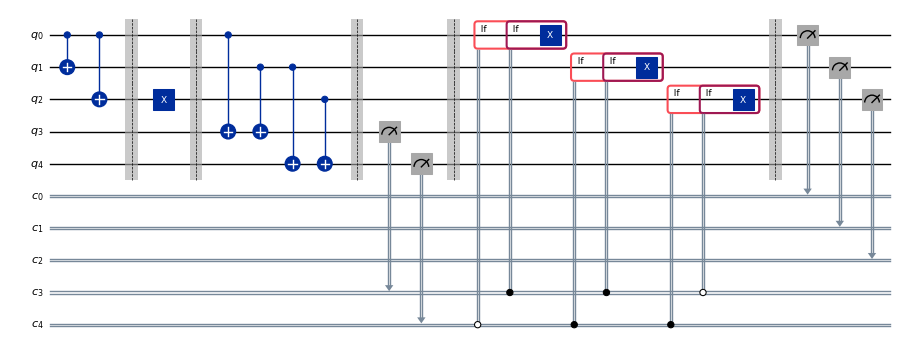

In [1122]:
qc.draw('mpl',scale= 0.5,cregbundle=False, fold = 50)

In [1123]:
shots = 1000

counts = backend_sim(qc, backend=FakeSherbrooke_backend , shots=shots)

errors = analyze_error_detection(counts, shots, plot_title='Simulated Error Detection')

errors = analyze_error_correction(counts, shots, plot_title='Simulated Error Correction')


{'01': 918, '11': 28, '00': 40, '10': 14}
Error Analysis:
No error (00): 4.00%
Q0 error (10): 1.40%
Q1 error (11): 2.80%
Q2 error (01): 91.80%
{'000': 879, '001': 59, '111': 16, '011': 28, '100': 11, '010': 6, '101': 1}

 LOGICAL Error Analysis:
Logical bit (by majority):
  Logical 0: 95.50%
  Logical 1: 4.50%

Raw measurements:
000: 87.90%
001: 5.90%
111: 1.60%
011: 2.80%
100: 1.10%
010: 0.60%
101: 0.10%


Error correction is working!

The memory error we have inserted post encoding has been detected ~92% of the time and it has been corrected 90% of the time. 

There are still errors that corrupt the other bits, but the logical bit output (majority of the qubits) is still correct 93% of the time.


## Can the error correction fix the noise from the simulation?

Let's insert identity gates to test..

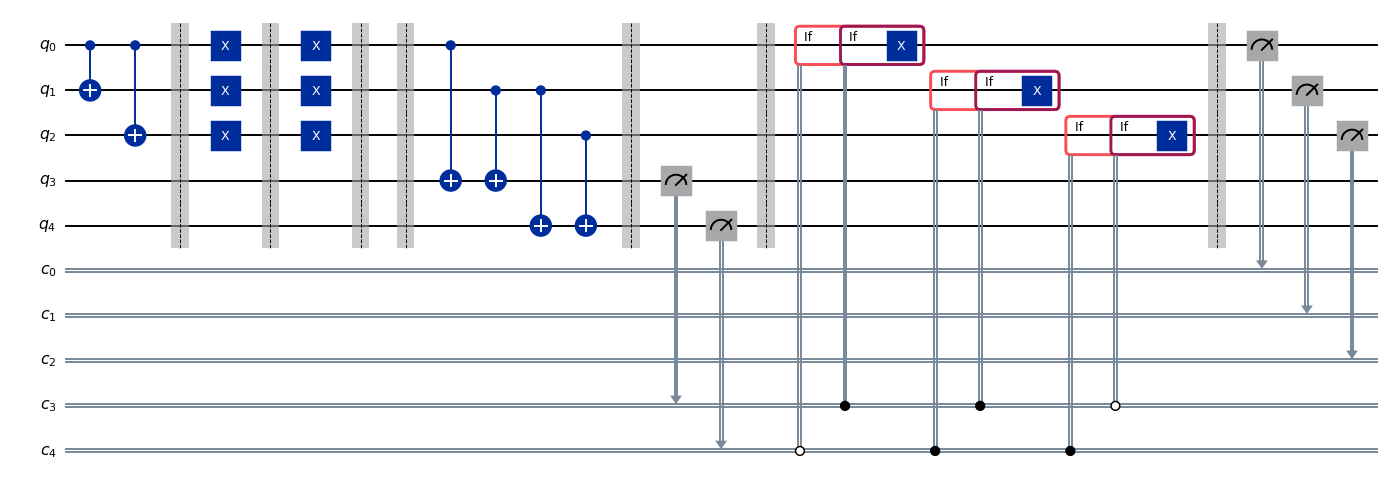

In [1125]:
qc = create_error_correction_circuit(error_prob=0.0,xgates=True)
qc.draw('mpl',scale= 0.7,cregbundle=False, fold = 50)

In [1126]:
counts = backend_sim(qc, backend=FakeSherbrooke_backend , shots=shots)

errors = analyze_error_detection(counts, shots, plot_title='Simulated Error detection')
errors = analyze_error_correction(counts, shots, plot_title='Simulated Error Correction')

{'11': 19, '10': 25, '00': 932, '01': 24}
Error Analysis:
No error (00): 93.20%
Q0 error (10): 2.50%
Q1 error (11): 1.90%
Q2 error (01): 2.40%
{'100': 37, '000': 886, '001': 55, '111': 2, '010': 15, '011': 4, '110': 1}

 LOGICAL Error Analysis:
Logical bit (by majority):
  Logical 0: 99.30%
  Logical 1: 0.70%

Raw measurements:
100: 3.70%
000: 88.60%
001: 5.50%
111: 0.20%
010: 1.50%
011: 0.40%
110: 0.10%


The error of the logical qubit is lower, with only a few logical errors!

## Simulating QEC vs error rates (noise)

We can construct an error model for our simulations

In [1127]:

def create_noise_model(T1=100_000, T2=50_000, gate_time=600, delay_time=1_000, e_gate1=0.005, e_gate2=0.01,idle_error=0.01):
    """
    Creates a noise model with thermal relaxation and gate errors.
    
    Args:
        T1 (int): T1 relaxation time in ns. Default 100_000 (100 µs)
        T2 (int): T2 relaxation time in ns. Default 50_000 (50 µs) 
        gate_time (int): Gate operation time in ns. Default 600
        delay_time (int): Delay time in ns. Default 1_000 (but arbitrary)
        e_gate1 (float): One qubit gate error probability. Default 0.005
        e_gate2 (float): Two qubit gate error probability. Default 0.01
        idle_error (float): Idle error probability. Default 0.01
        
    Returns:
        NoiseModel: Configured noise model
    """
    # Define noise model
    noise_model = NoiseModel()
    
    # Add thermal relaxation errors
    # thermal_error = thermal_relaxation_error(T1, T2, gate_time)
    # noise_model.add_all_qubit_quantum_error(thermal_error, ['x'])

    # delay_error = thermal_relaxation_error(T1, T2, delay_time)
    # noise_model.add_all_qubit_quantum_error(delay_error, ['delay'])

    # Add gate errors
    p_gate1 = e_gate2/10
    error_gate1 = pauli_error([("X", p_gate1), ("I", 1 - p_gate1)])
    error_gate2 = pauli_error([("X", e_gate2), ("I", 1 - e_gate2)])
    error_gate2 = error_gate2.tensor(error_gate2)

    noise_model.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3","x","h","id"])
    # noise_model.add_all_qubit_quantum_error(error_gate2, ["cx", "ecr"])
    noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"])

    idle_error_gate = pauli_error([("X", idle_error), ("I", 1 - idle_error)])
    noise_model.add_all_qubit_quantum_error(idle_error_gate, ['delay'])

    return noise_model

# Create default noise model and print it
noise_model = create_noise_model()
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rz', 'sx', 'u1', 'u2', 'u3', 'x']
  Instructions with noise: ['u3', 'delay', 'id', 'u2', 'u1', 'x', 'h', 'cx']
  All-qubits errors: ['u1', 'u2', 'u3', 'x', 'h', 'id', 'cx', 'delay']


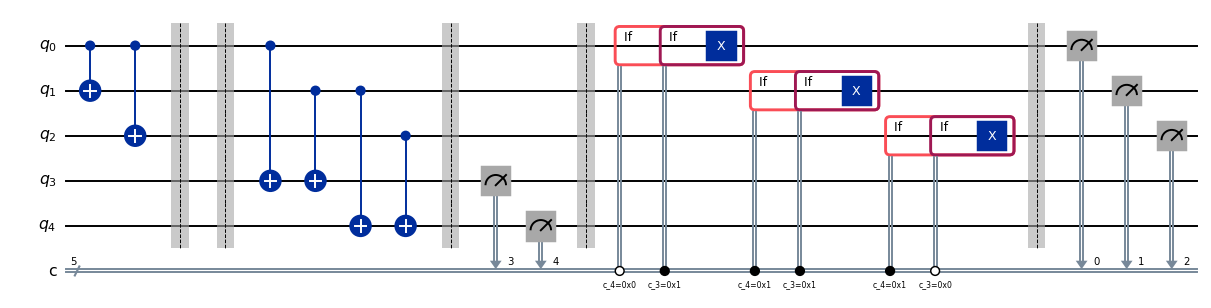

In [1128]:
qc = create_error_correction_circuit(error_prob=0.3, apply_correction=True,identity_gates=False, delay=False)
qc.draw('mpl',scale= 0.7,cregbundle=True, fold = 50)

Counts: {'10111': 67, '00000': 313, '01000': 132, '11000': 130, '10000': 138, '01111': 58, '01011': 4, '00010': 4, '00111': 29, '10110': 6, '11111': 62, '10100': 6, '01010': 3, '11100': 4, '10001': 2, '00001': 7, '00100': 5, '01101': 2, '10101': 2, '11001': 3, '11110': 4, '01001': 6, '10010': 2, '00011': 2, '11011': 3, '01100': 2, '00110': 2, '10011': 2}
{'01': 225, '00': 362, '10': 207, '11': 206}
Error Analysis:
No error (00): 36.20%
Q0 error (10): 20.70%
Q1 error (11): 20.60%
Q2 error (01): 22.50%
{'111': 216, '000': 713, '110': 11, '010': 9, '011': 12, '001': 17, '100': 18, '101': 4}

 LOGICAL Error Analysis:
Logical bit (by majority):
  Logical 0: 75.70%
  Logical 1: 24.30%

Raw measurements:
111: 21.60%
000: 71.30%
110: 1.10%
010: 0.90%
011: 1.20%
001: 1.70%
100: 1.80%
101: 0.40%


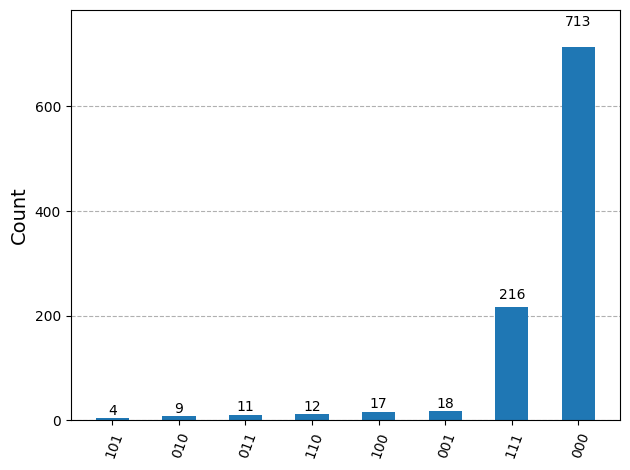

In [ ]:
error = 0.3

error2Q = .01

noise_model = create_noise_model(idle_error=0.0, e_gate1=0.0, e_gate2=error2Q)

simulator = AerSimulator(noise_model=noise_model)

# Run simulation
shots= 1000

# Initialize lists to store results for each trial
all_counts = []

for shot in range(shots):

    qc = create_error_correction_circuit(error_prob=error)
    # qc = transpile(qc, simulator,optimization_level=0)
    result = simulator.run(qc, shots=1).result()
    counts = result.get_counts()
    # Append results for this trial
    if not all_counts:
        all_counts = counts
    else:
        for key in counts:
            if key in all_counts:
                all_counts[key] += counts[key]
            else:
                all_counts[key] = counts[key]

print("Counts:", all_counts)

errors_detected = analyze_error_detection(all_counts, shots, plot_title='Simulated Error Detection')
errors_corrected = analyze_error_correction(all_counts, shots, plot_title='Simulated Error Correction')

# Extract just the data bits (first 3 bits) from the counts
data_counts = {'000': 0, '001': 0, '010': 0, '011': 0, '100': 0, '101': 0, '110': 0, '111': 0}
for bitstring, count in all_counts.items():
    data_bits = bitstring[-3:]  # First 3 bits are the data bits
    data_counts[data_bits] += count

plot_histogram(data_counts, sort ='value')


Good. The logical error rate is lower than the single qubit error rate. 

## Lower overall error with error correction in a noisy circuit?

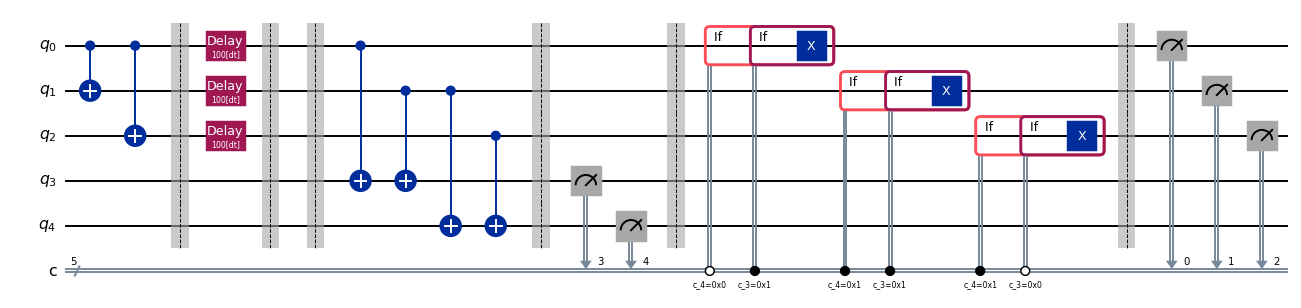

In [1139]:
qc = create_error_correction_circuit(error_prob=0.0, delay=True,apply_correction=True)
qc.draw('mpl',scale= 0.7,cregbundle=True, fold = 50)

{'01000': 14, '00000': 960, '11000': 18, '10000': 7, '01111': 1}
{'000': 960, '001': 0, '010': 14, '011': 1, '100': 7, '101': 0, '110': 18, '111': 0}


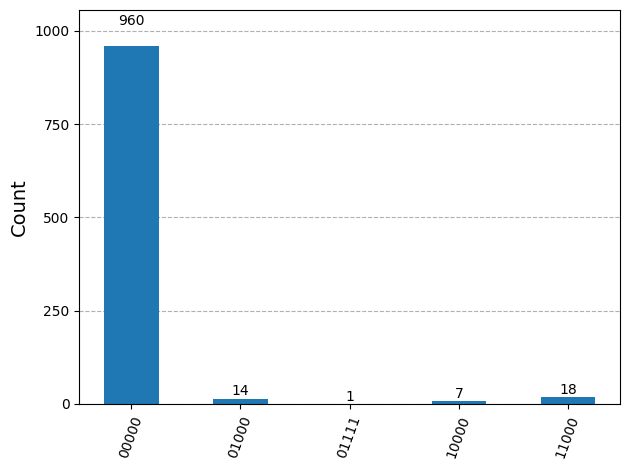

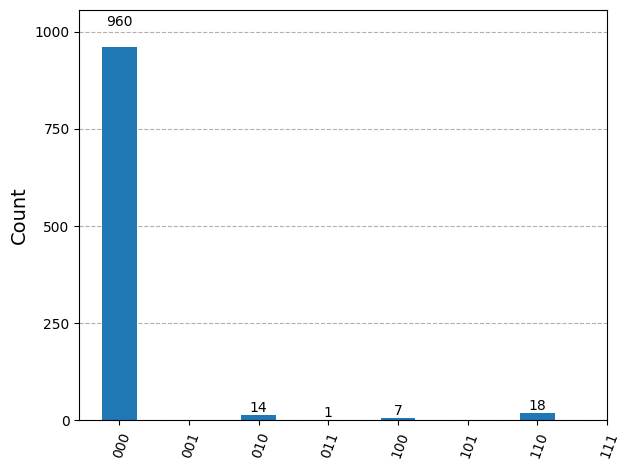

In [1151]:
shots=1000
noise_model = create_noise_model(idle_error=0.01,e_gate2=0.0,e_gate1=0.0)

counts = ideal_sim(qc,shots=shots)
print(counts)

# Extract just the data bits (first 3 bits) from the counts
data_counts = {'000': 0, '001': 0, '010': 0, '011': 0, '100': 0, '101': 0, '110': 0, '111': 0}
for bitstring, count in counts.items():
    data_bits = bitstring[:3]  # First 3 bits are the data bits
    data_counts[data_bits] += count

print(data_counts)
display(plot_histogram(counts))
plot_histogram(data_counts)

In [1147]:
error_rates = np.linspace(0.0, 1.0, 20)  # Create 10 evenly spaced points from 0 to 0.02
detected_rates = []
corrected_rates = []

shots = 10000
for error in error_rates:

    noise_model = create_noise_model(idle_error=error,e_gate2=0.0)

    # Run simulation
    simulator = AerSimulator(noise_model=noise_model)
    qc = transpile(qc, simulator)
    result = simulator.run(qc, shots=shots).result()
    counts = result.get_counts()
    print("Counts:", counts)
    
    errors_detected = analyze_error_detection(counts, shots, show_plot=False);
    errors_corrected = analyze_error_correction(counts, shots,  show_plot=False);
    
    # detected_rates.append(errors_detected['no_error'])
    # corrected_rates.append(errors_corrected['000'])

    detected_rates.append(errors_detected['no_error'])
    corrected_rates.append(errors_corrected['logical_results']['logical_0'])

    # print(f"\nError rate p = {error}")
    # print(f"No errors detected: {errors_detected['no_error']:.2f}%") 
    # print(f"Successfully corrected to |000>: {errors_corrected['000']:.2f}%")

Counts: {'00000': 10000}
{'00': 10000}
Error Analysis:
No error (00): 100.00%
Q0 error (10): 0.00%
Q1 error (11): 0.00%
Q2 error (01): 0.00%
{'000': 10000}

 LOGICAL Error Analysis:
Logical bit (by majority):
  Logical 0: 100.00%
  Logical 1: 0.00%

Raw measurements:
000: 100.00%
Counts: {'01000': 472, '00000': 8553, '11000': 476, '10000': 432, '00111': 1, '11111': 25, '01111': 22, '10111': 19}
{'10': 494, '00': 8554, '11': 501, '01': 451}
Error Analysis:
No error (00): 85.54%
Q0 error (10): 4.94%
Q1 error (11): 5.01%
Q2 error (01): 4.51%
{'000': 9933, '111': 67}

 LOGICAL Error Analysis:
Logical bit (by majority):
  Logical 0: 99.33%
  Logical 1: 0.67%

Raw measurements:
000: 99.33%
111: 0.67%
Counts: {'01000': 866, '00000': 7159, '10000': 816, '11000': 839, '01111': 94, '10111': 117, '00111': 13, '11111': 96}
{'10': 960, '00': 7172, '01': 933, '11': 935}
Error Analysis:
No error (00): 71.72%
Q0 error (10): 9.60%
Q1 error (11): 9.35%
Q2 error (01): 9.33%
{'000': 9680, '111': 320}

 LO

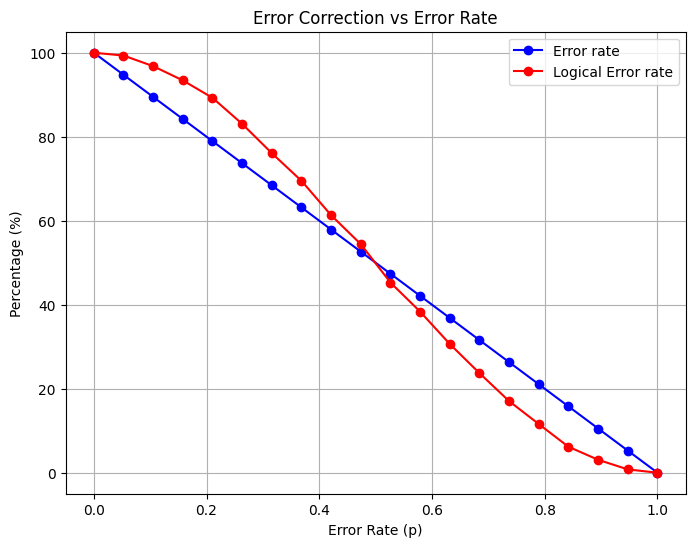

In [1148]:
# Plot results
plt.figure(figsize=(8,6))
plt.plot(error_rates, (1-error_rates)*100, 'bo-', label='Error rate')
plt.plot(error_rates, corrected_rates, 'ro-', label='Logical Error rate')
plt.xlabel('Error Rate (p)')
plt.ylabel('Percentage (%)')
plt.title('Error Correction vs Error Rate')
plt.legend()
plt.grid(True)
plt.show()

So if we assume that only classical bit flip errors during the idle time after encoding (similar to memory errors)....

*then* we can account for a very large amount of error.

Does this hold if we add in error from the CNOT gates themselves?

In [74]:
error_rates = np.linspace(0, 0.1, 10) 
detected_rates = []
corrected_rates = []

shots=10000

for error in error_rates:

    noise_model = create_noise_model(idle_error=0.0,e_gate2=error)

    # Run simulation
    simulator = AerSimulator(noise_model=noise_model)
    qc = transpile(qc, simulator)
    result = simulator.run(qc, shots=shots).result()
    counts = result.get_counts()
    print("Counts:", counts)
    
    errors_detected = analyze_error_detection(counts, shots, show_plot=False);
    errors_corrected = analyze_error_correction(counts, shots,  show_plot=False);
    
    # detected_rates.append(errors_detected['no_error'])
    # corrected_rates.append(errors_corrected['000'])

    detected_rates.append(errors_detected['no_error'])
    corrected_rates.append(errors_corrected['logical_results']['logical_0'])

    # print(f"\nError rate p = {error}")
    # print(f"No errors detected: {errors_detected['no_error']:.2f}%") 
    # print(f"Successfully corrected to |000>: {errors_corrected['000']:.2f}%")

Counts: {'00000': 10000}
{'00': 10000}
Error Analysis:
No error (00): 100.00%
Q0 error (10): 0.00%
Q1 error (11): 0.00%
Q2 error (01): 0.00%
{'000': 10000}

 LOGICAL Error Analysis:
Logical bit (by majority):
  Logical 0: 100.00%
  Logical 1: 0.00%

Raw measurements:
000: 100.00%
Counts: {'01000': 123, '00000': 8722, '10000': 89, '00001': 111, '01001': 213, '11000': 91, '00010': 109, '11111': 98, '10100': 192, '01111': 5, '10110': 93, '00100': 109, '11010': 4, '01101': 2, '00110': 2, '01011': 5, '10101': 1, '11001': 2, '10111': 1, '10010': 4, '00101': 1, '00011': 1, '11011': 4, '01110': 1, '01100': 2, '11110': 3, '10001': 7, '11100': 2, '00111': 1, '11101': 2}
{'10': 351, '00': 9056, '01': 387, '11': 206}
Error Analysis:
No error (00): 90.56%
Q0 error (10): 3.51%
Q1 error (11): 2.06%
Q2 error (01): 3.87%
{'000': 9025, '100': 333, '010': 117, '111': 105, '001': 305, '011': 99, '101': 6, '110': 10}

 LOGICAL Error Analysis:
Logical bit (by majority):
  Logical 0: 97.80%
  Logical 1: 2.20

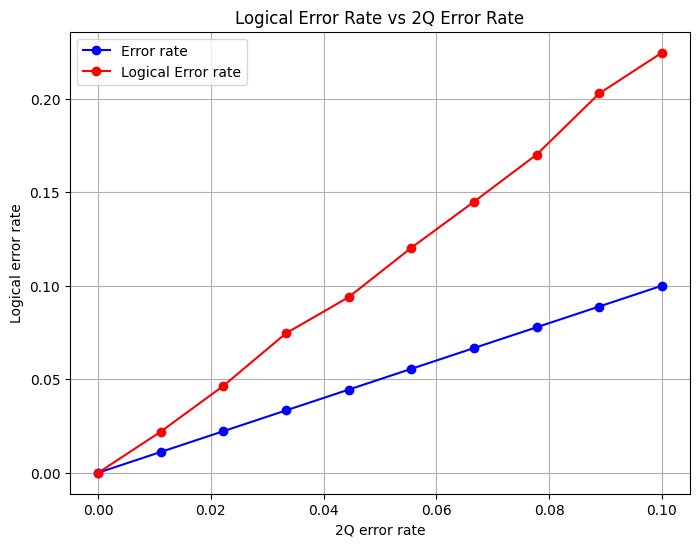

In [75]:
plt.figure(figsize=(8,6))
plt.plot(error_rates, (error_rates), 'bo-', label='Error rate')
plt.plot(error_rates, 1-np.array(corrected_rates)/100, 'ro-', label='Logical Error rate')
plt.xlabel('2Q error rate')
plt.ylabel('Logical error rate')
plt.title('Logical Error Rate vs 2Q Error Rate')
plt.legend()
plt.grid(True)
plt.show()

Nope. Including errors from the gates make it always worse...

Hmm this could get tricky..

## 9 qubit error correction

In [1153]:
noise_model = NoiseModel()

def create_Shor_error_correction_circuit(error_prob=0.01, apply_correction=True, delay=False, phase_syndrome=True, bit_syndrome=True, initial_zero = True):
    # Create a quantum circuit with 9 data qubits and 8 auxiliary qubits for syndrome measurement
    n_qubits = 9
    n_aux = 8
    cr = ClassicalRegister(n_qubits + n_aux,'c')
    qr = QuantumRegister(n_qubits + n_aux,'q')
    qc = QuantumCircuit(qr, cr)


    if initial_zero:
        # Initialize first qubit to |+⟩ state
        qc.reset(qr[0])
    else:
        qc.reset(qr[0])
        qc.h(qr[0])

    # Encode logical |0⟩ state into 9-qubit Shor code
    # First level - 3 qubit bit flip code
    qc.cx(qr[0], qr[3])
    qc.cx(qr[0], qr[6])
    
    # Second level - Each block gets 3 qubit bit flip code
    for i in [0,3,6]:
        qc.h(qr[i])
        qc.cx(qr[i], qr[i+1])
        qc.cx(qr[i], qr[i+2])

    qc.barrier()

    if delay == True:
        # Add delays between encoding and error
        for i in range(9):
            qc.delay(100, qr[i])
        qc.barrier()

    # Add random errors with given probability on each qubit
    import random

    for i in range(9):
        if random.random() < error_prob:
            qc.x(qr[i])  # bit flip error
        
    for i in range(9):
        if random.random() < error_prob:
            qc.z(qr[i])  # bit flip error

    qc.barrier()

    if bit_syndrome:
        # Measure bit flip syndromes using auxiliary qubits 0-5
        # For first block
        qc.cx(qr[0], qr[9])
        qc.cx(qr[1], qr[9])
        qc.cx(qr[1], qr[10])
        qc.cx(qr[2], qr[10])
        
        qc.barrier()

        # For second block
        qc.cx(qr[3], qr[11])
        qc.cx(qr[4], qr[11])
        qc.cx(qr[4], qr[12])
        qc.cx(qr[5], qr[12])
        
        qc.barrier()

        # For third block
        qc.cx(qr[6], qr[13])
        qc.cx(qr[7], qr[13])
        qc.cx(qr[7], qr[14])
        qc.cx(qr[8], qr[14])

        qc.barrier()

    if phase_syndrome:
        # Phase flip syndromes using auxiliary qubits 6-7
        # Apply H gates before syndrome measurement
        for i in range(9):
            qc.h(qr[i])
        
        # First phase flip syndrome
        for i in range(6):
            qc.cx(qr[i], qr[15])
        
        qc.barrier()

        # Second phase flip syndrome 
        for i in range(3,9):
            qc.cx(qr[i], qr[16])
        
        qc.barrier()

        # Apply H gates after syndrome measurement
        for i in range(9):
            qc.h(qr[i])

        qc.barrier()
    


    # Measure aux qubits
    for i in range(n_aux):
        qc.measure(qr[i+n_qubits], cr[i+n_qubits])

    qc.barrier()

    if apply_correction:
        # Apply bit flip corrections based on syndromes
        # First block
        with qc.if_test((cr[10], 0)):
            with qc.if_test((cr[9], 1)):
                qc.x(qr[0])
        with qc.if_test((cr[10], 1)):
            with qc.if_test((cr[9], 1)):
                qc.x(qr[1])
        with qc.if_test((cr[10], 1)):
            with qc.if_test((cr[9], 0)):
                qc.x(qr[2])
        
        qc.barrier()
      
        # Second block
        with qc.if_test((cr[12], 0)):
            with qc.if_test((cr[11], 1)):
                qc.x(qr[3])
        with qc.if_test((cr[12], 1)):
            with qc.if_test((cr[11], 1)):
                qc.x(qr[4])
        with qc.if_test((cr[12], 1)):
            with qc.if_test((cr[11], 0)):
                qc.x(qr[5])
        
        qc.barrier()
        
        # Third block
        with qc.if_test((cr[14], 0)):
            with qc.if_test((cr[13], 1)):
                qc.x(qr[6])
        with qc.if_test((cr[14], 1)):
            with qc.if_test((cr[13], 1)):
                qc.x(qr[7])
        with qc.if_test((cr[14], 1)):
            with qc.if_test((cr[13], 0)):
                qc.x(qr[8])
        
        qc.barrier()
        
        # Phase flip corrections
        with qc.if_test((cr[16], 0)):
            with qc.if_test((cr[15], 1)):
                qc.z(qr[0])
        with qc.if_test((cr[16], 1)):
            with qc.if_test((cr[15], 1)):
                qc.z(qr[3])
        with qc.if_test((cr[16], 1)):
            with qc.if_test((cr[15], 0)):
                qc.z(qr[6])


    qc.barrier()
    
    # Decode logical qubit

    # Second level decoded first - Each block gets 3 qubit bit flip code
    for i in [0,3,6]:
        qc.cx(qr[i], qr[i+2])
        qc.cx(qr[i], qr[i+1])
        qc.h(i)

    qc.cx(qr[0], qr[6])
    qc.cx(qr[0], qr[3])

    if not initial_zero:
        qc.h(0)

    qc.barrier()

    # Measure data qubits
    for i in range(n_qubits):
        qc.measure(qr[i], cr[i])
    
    return qc

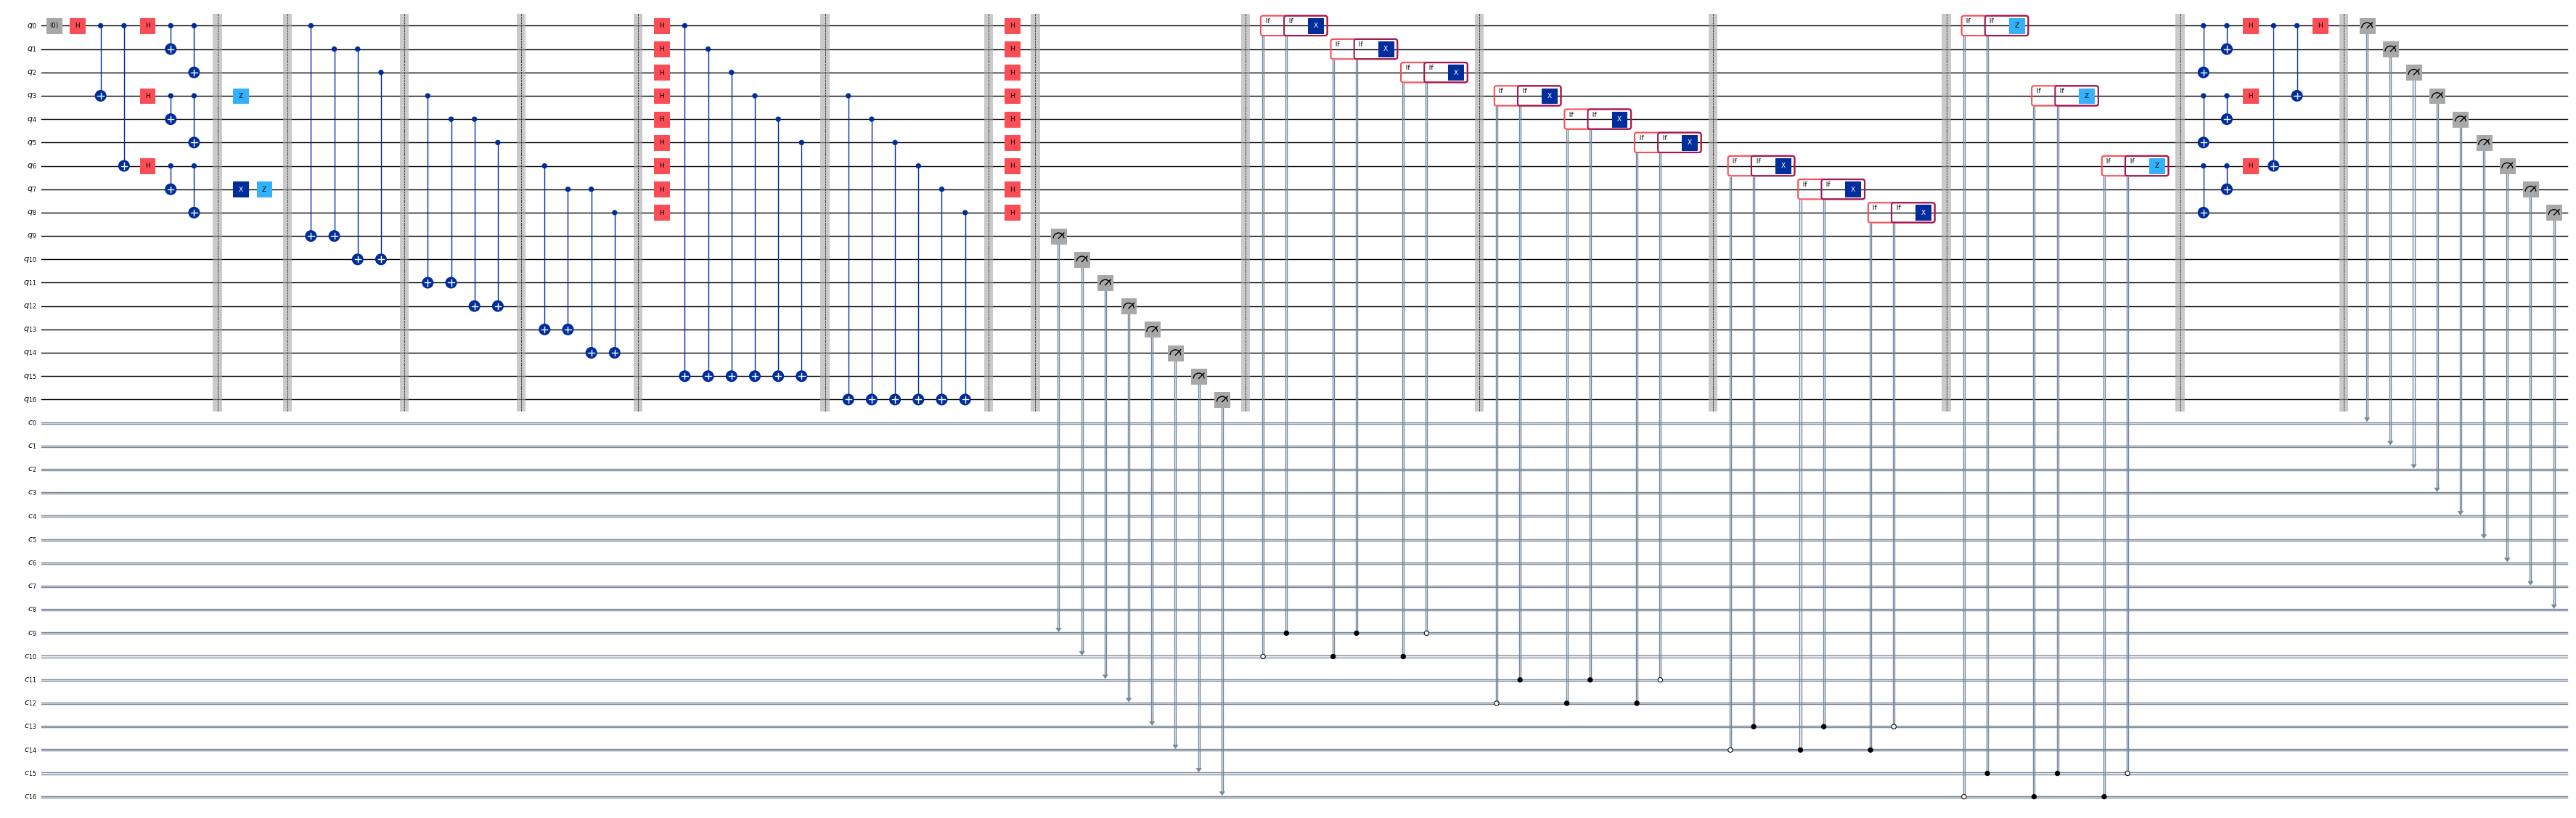

In [1158]:
qc = create_Shor_error_correction_circuit(apply_correction=True, error_prob=0.1, delay=False, initial_zero=False)
qc.draw(output='mpl', cregbundle=False, scale = 0.5,fold = 120)

In [1159]:
noise_model = NoiseModel()
shots= 1000
counts = ideal_sim(qc,shots=shots)
# Print data qubits (first 9 bits) and syndrome bits (last 8 bits) separately
def print_measurement_results(counts):
    for bitstring, count in counts.items():
        data_qubits = bitstring[8:]
        syndrome = bitstring[:8]
        print(f"Full bitstring: {bitstring}, Data qubits: {data_qubits}, Syndrome: {syndrome}, Count: {count}")
        
print_measurement_results(counts)

Full bitstring: 01110000000000000, Data qubits: 000000000, Syndrome: 01110000, Count: 1000


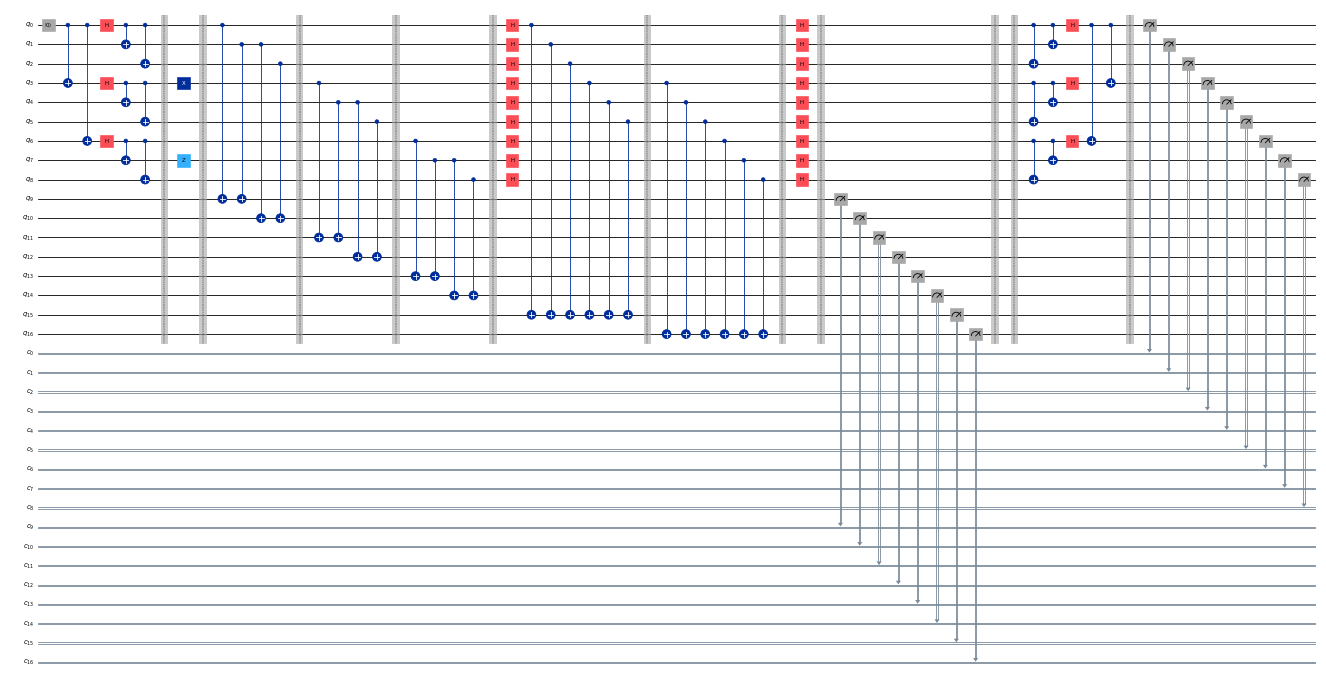

In [710]:
qc = create_Shor_error_correction_circuit(apply_correction=False, error_prob=0.1)
qc.draw(output='mpl', cregbundle=False, scale = 0.3,fold = 200)

In [711]:
noise_model = NoiseModel()
shots= 1000
counts = ideal_sim(qc,shots=shots)
print_measurement_results(counts)

Full bitstring: 10000100001110000, Data qubits: 001110000, Syndrome: 10000100, Count: 1000


In [720]:
def decode_syndrome(syndrome_bits):
    """Decode error syndrome bits to determine error locations"""
    error_locations = []
    
    # Split syndrome into bit flip and phase flip syndromes
    syndrome_bits = syndrome_bits[::-1]  # Reverse the syndrome bits
    bit_syndrome = syndrome_bits[:6]  # Last 6 bits for bit flip detection
    phase_syndrome = syndrome_bits[-2:] # First 2 bits for phase flip detection

    # Print syndromes for debugging
    print(f"Bit flip syndrome: {bit_syndrome}")
    print(f"Phase flip syndrome: {phase_syndrome}")
    
    # Check bit flip syndromes (2 syndrome bits per data block)
    for i in range(0, 6, 2):
        syndrome = bit_syndrome[i:i+2]
        if syndrome == '01':
            error_locations.append(f"Bit flip in block {i//2}, (qubit {i+2})")
        elif syndrome == '10': 
            error_locations.append(f"Bit flip in block {i//2}, (qubit {i+1})")
        elif syndrome == '11':
            error_locations.append(f"Bit flip in block {i//2}, (qubit {i})")
    # Check phase flip syndrome
    if phase_syndrome == '10':
        error_locations.append("Phase flip in block 0")
    elif phase_syndrome == '11':
        error_locations.append("Phase flip in block 1") 
    elif phase_syndrome == '01':
        error_locations.append("Phase flip in block 2")

    return error_locations


def print_measurement_results(counts):
    print("\nDecoding measurement results:")
    # Get first bitstring and count
    bitstring, count = max(counts.items(), key=lambda x: x[1])

    # Split into data qubits (last 9) and error syndrome bits (first)
    # (order is odd as they're REVERSED)
    data_bits = bitstring[9:]
    syndrome_bits = bitstring[:9]

    print(f"\nFull Measurement: {bitstring} (occurred {count} times)")
    print(f"Data qubits: {data_bits}")


    print(f"Error syndrome: {syndrome_bits}")
    syndrome_errors = decode_syndrome(syndrome_bits)


    if syndrome_errors:
        print("\nSyndrome indicates errors at:")
        for error in syndrome_errors:
            print(f"  {error}")
    else:
        print("\nSyndrome indicates no errors")

print_measurement_results(counts)


Decoding measurement results:

Full Measurement: 10000100001110000 (occurred 1000 times)
Data qubits: 01110000
Error syndrome: 100001000
Bit flip syndrome: 000100
Phase flip syndrome: 01

Syndrome indicates errors at:
  Bit flip in block 1, (qubit 4)
  Phase flip in block 2


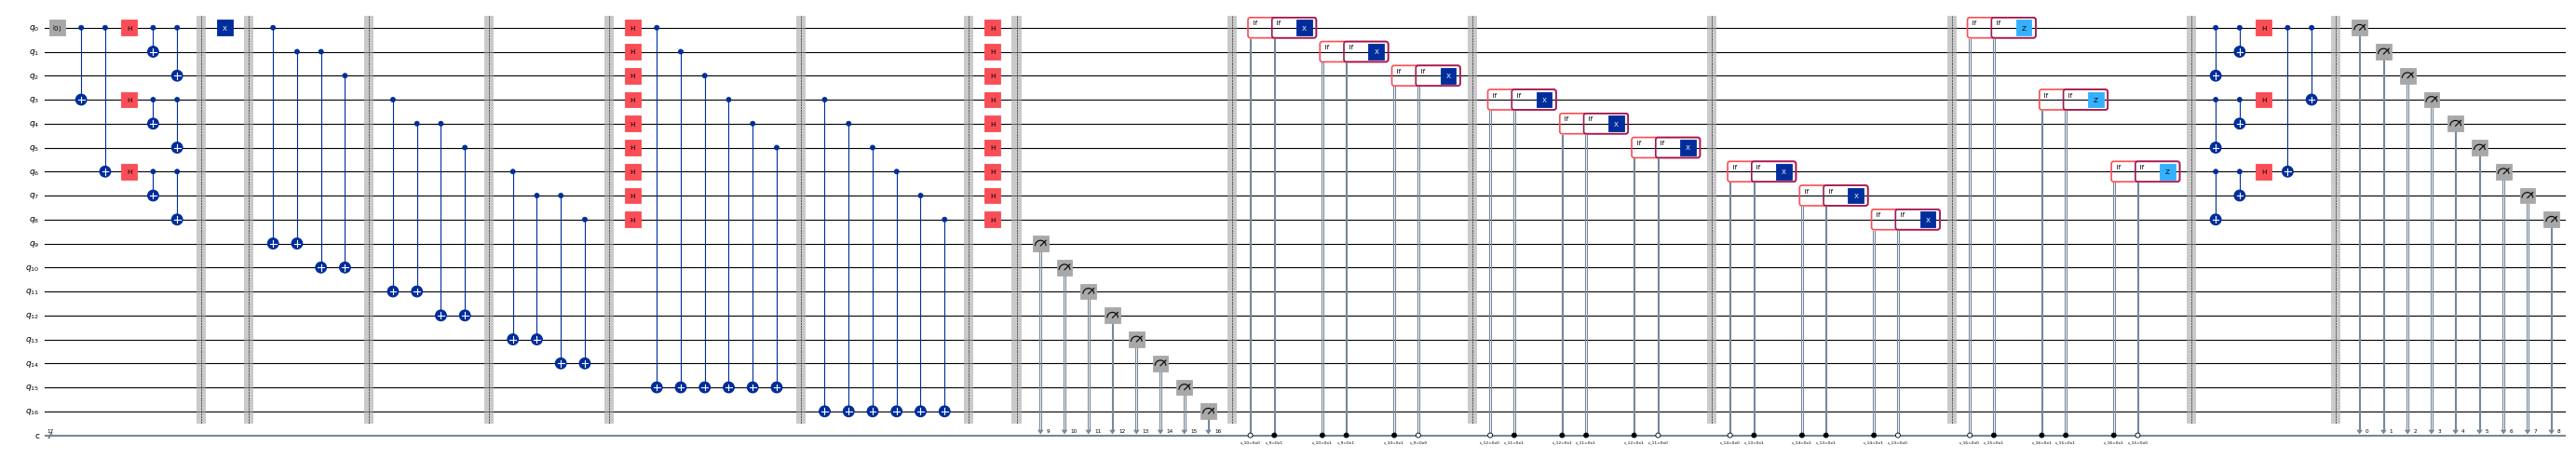

In [1199]:
qc = create_Shor_error_correction_circuit(apply_correction=True, error_prob=0.05)
qc.draw(output='mpl', cregbundle=True, scale = 0.4,fold = 200)

In [1211]:
trials = 100
shots=1
for trial in range(trials):
    qc = create_Shor_error_correction_circuit(apply_correction=True, error_prob=0.01)
    qc = transpile(qc, simulator)
    result = simulator.run(qc, shots=shots).result()
    counts = result.get_counts()
    # Append counts together
    if trial == 0:
        combined_counts = counts
    else:
        for bitstring, count in counts.items():
            if bitstring in combined_counts:
                combined_counts[bitstring] += count
            else:
                combined_counts[bitstring] = count

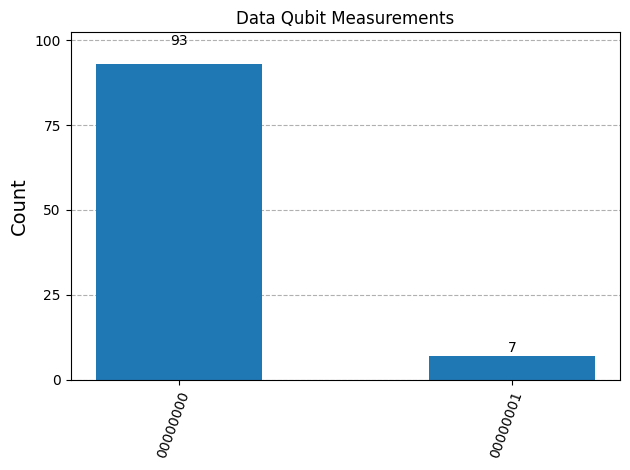

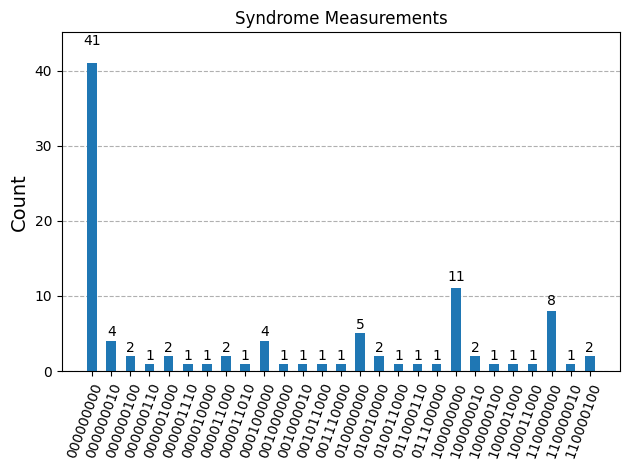

In [1212]:
# Separate combined counts into data and syndrome bits
data_counts = {}
syndrome_counts = {}

for bitstring, count in combined_counts.items():
    # Last 9 bits are data qubits
    data_bits = bitstring[9:]
    # First 9 bits are syndrome bits 
    syndrome_bits = bitstring[:9]
    
    # Add to data counts
    if data_bits in data_counts:
        data_counts[data_bits] += count
    else:
        data_counts[data_bits] = count
        
    # Add to syndrome counts
    if syndrome_bits in syndrome_counts:
        syndrome_counts[syndrome_bits] += count 
    else:
        syndrome_counts[syndrome_bits] = count

# Plot separate histograms
display(plot_histogram(data_counts, title="Data Qubit Measurements"))
plot_histogram(syndrome_counts, title="Syndrome Measurements")


In [1226]:
trials = 200
shots = 1
error_probs = np.linspace(0, 0.1, 10)

# Dictionary to store combined counts for each error probability
error_combined_counts = {}

for error_prob in error_probs:
    # Initialize combined counts for this error probability
    combined_counts = {}
    print(error_prob)

    for trial in range(trials):
        qc = create_Shor_error_correction_circuit(apply_correction=True, error_prob=error_prob)
        qc = transpile(qc, simulator)
        result = simulator.run(qc, shots=shots).result()
        counts = result.get_counts()
        
        # Append counts together for this error probability
        for bitstring, count in counts.items():
            if bitstring in combined_counts:
                combined_counts[bitstring] += count
            else:
                combined_counts[bitstring] = count
    
    # Store the combined counts for this error probability
    error_combined_counts[error_prob] = combined_counts

0.0
0.011111111111111112
0.022222222222222223
0.03333333333333333
0.044444444444444446
0.05555555555555556
0.06666666666666667
0.07777777777777778
0.08888888888888889
0.1


C:\Users\bobni\AppData\Local\Temp\ipykernel_31292\2670133019.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  num_errors = sum(1 for bit in data_bits if bit == '1')


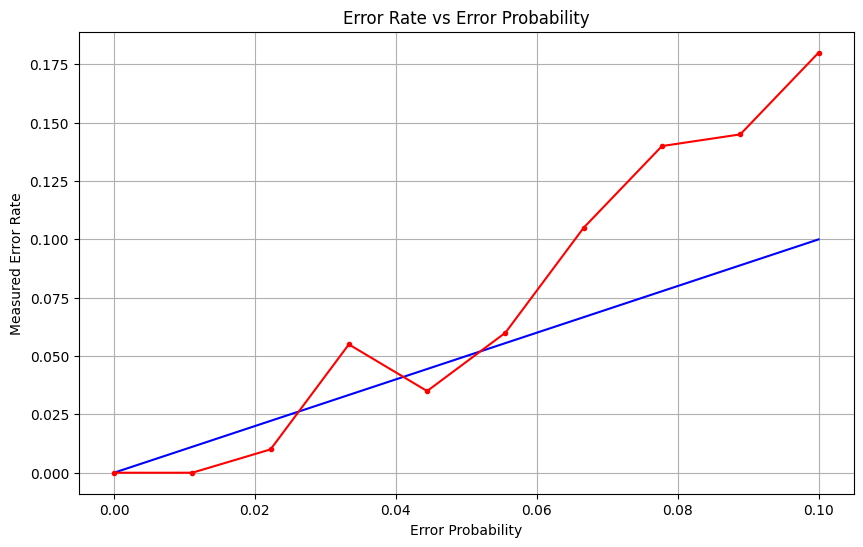

In [1228]:
# Calculate error rates for each error probability
error_rates = []

for prob in error_probs:
    total_errors = 0
    total_measurements = 0
    
    for bitstring, count in error_combined_counts[prob].items():
        # Split into data and syndrome bits
        data_bits = bitstring[9:]
        syndrome_bits = bitstring[:9]
        
        # Count errors by checking if data bits are not zeros
        num_errors = sum(1 for bit in data_bits if bit == '1')
        
        total_errors += num_errors * count
        total_measurements += count
        
    error_rate = total_errors / total_measurements
    error_rates.append(error_rate)

# Plot error rates vs error probabilities
plt.figure(figsize=(10,6))
plt.plot(error_probs, error_probs, '-b')
plt.plot(error_probs, error_rates, '.-r')
plt.xlabel('Error Probability')
plt.ylabel('Measured Error Rate')
plt.title('Error Rate vs Error Probability')
plt.grid(True)
plt.show()

## Logical Error rate below qubit error rate for small qubit error rates

This shows that for small probabilities of single qubit error rates the logical qubit error rate is reduced.

We can try to analytically predict the single qubit error rate at which the logical error rate is larger by considering the probabilities of the cases of a single error.

if the single qubit probability for an error is p then:

The probability of no error is: $(1-p)^9$

>so for 1% single qubit error probabilty, the probability of no errors on 9 qubits is 99%^9


The probability of (8 non-errors) and one error is then: $p(1-p)^8$

Adding these up we get the probability of no error or a single (out of 9 possible) errors as: $(1-p)^9 + 9p(1-p)^8$

We can plot this to see when it is equal to p.

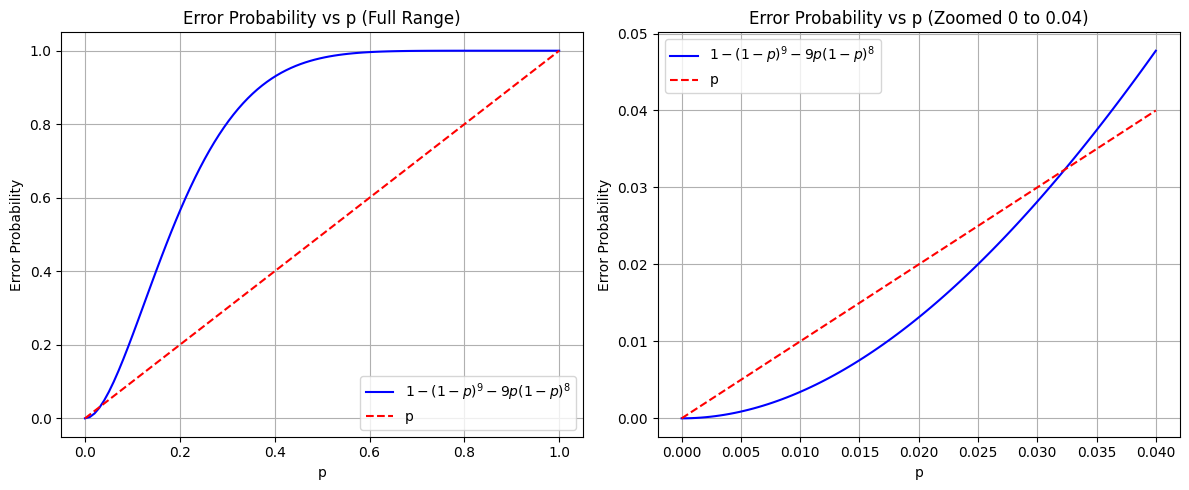

In [1229]:
import numpy as np
import matplotlib.pyplot as plt

# Create array of p values from 0 to 1
p = np.linspace(0, 1, 100)

# Calculate 1-(1-p)^9 - 9p(1-p)^8
y = 1 - (1-p)**9 - 9*p*(1-p)**8

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# Plot full range in first subplot
ax1.plot(p, y, '-b', label='$1-(1-p)^9 - 9p(1-p)^8$')
ax1.plot(p, p, '--r', label='p')
ax1.set_xlabel('p')
ax1.set_ylabel('Error Probability')
ax1.set_title('Error Probability vs p (Full Range)')
ax1.grid(True)
ax1.legend()

# Create zoomed array from 0 to 0.04
p_zoom = np.linspace(0, 0.04, 100)
y_zoom = 1 - (1-p_zoom)**9 - 9*p_zoom*(1-p_zoom)**8

# Plot zoomed range in second subplot
ax2.plot(p_zoom, y_zoom, '-b', label='$1-(1-p)^9 - 9p(1-p)^8$')
ax2.plot(p_zoom, p_zoom, '--r', label='p')
ax2.set_xlabel('p')
ax2.set_ylabel('Error Probability')
ax2.set_title('Error Probability vs p (Zoomed 0 to 0.04)')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()


# END